In [1]:
%%capture
!pip install gradio beautifulsoup4 yfinance torch

In [2]:
import gradio as gr
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import requests
from bs4 import BeautifulSoup
import re
import io
from PIL import Image
import math
from datetime import datetime, timedelta

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

DEBUG = True
def debug_print(msg):
    if DEBUG:
        print(msg)

In [3]:
# FOMC Dates Scraper
def get_fomc_dates(start_date, end_date):
    url = "https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            debug_print(f"Error: Received status code {response.status_code}")
            return []
        soup = BeautifulSoup(response.text, "html.parser")
        date_objs = []
        for text in soup.stripped_strings:
            matches = re.findall(r'([A-Za-z]+ \d{1,2}, \d{4})', text)
            for date_str in matches:
                try:
                    dt = datetime.strptime(date_str, "%B %d, %Y")
                    if dt not in date_objs:
                        date_objs.append(dt)
                except Exception:
                    continue
        date_objs = sorted(date_objs)
        start_dt = pd.to_datetime(start_date)
        end_dt = pd.to_datetime(end_date)
        filtered_dates = [dt for dt in date_objs if start_dt <= dt <= end_dt]
        return filtered_dates
    except Exception as e:
        debug_print(f"Error scraping FOMC dates: {e}")
        return []

In [4]:
# Indicator Functions
def exp_average(series, period):
    return series.ewm(span=period, adjust=False).mean()

def wilder_average(series, length):
    return series.ewm(alpha=1/length, adjust=False).mean()

def weighted_moving_average(series, window):
    weights = np.arange(1, window+1)
    return series.rolling(window).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

def t3(source, length=21, vf=0.7):
    ema1 = exp_average(source, length)
    ema2 = exp_average(ema1, length)
    gd1 = ema1*(1+vf) - ema2*vf
    ema11 = exp_average(gd1, length)
    ema22 = exp_average(ema11, length)
    gd2 = ema11*(1+vf) - ema22*vf
    ema111 = exp_average(gd2, length)
    ema222 = exp_average(ema111, length)
    gd3 = ema111*(1+vf) - ema222*vf
    return gd3

def vwma(series, window, volume):
    return (series*volume).rolling(window=window, min_periods=window).sum()/volume.rolling(window=window, min_periods=window).sum()

def rsi_function(close, sensitivity, rsiPeriod, rsiBase):
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=rsiPeriod, min_periods=rsiPeriod).mean()
    avg_loss = loss.rolling(window=rsiPeriod, min_periods=rsiPeriod).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100/(1+rs))
    rsi = rsi.fillna(50)
    rsi_adj = sensitivity*(rsi-rsiBase)
    return rsi_adj.clip(lower=0, upper=20)

def download_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=pd.to_datetime(start_date), end=pd.to_datetime(end_date))
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0].lower() for col in df.columns]
    else:
        df.columns = [str(col).lower() for col in df.columns]
    return df

def compute_bressert(df, n_period=8, r_period=13):
    df['Ln'] = df['low'].rolling(window=n_period, min_periods=1).min()
    df['Hn'] = df['high'].rolling(window=n_period, min_periods=1).max()
    df['Y'] = ((df['close']-df['Ln'])/(df['Hn']-df['Ln']))*100
    df['X'] = exp_average(df['Y'], r_period)
    df['Lxn'] = df['X'].rolling(window=n_period, min_periods=1).min()
    df['Hxn'] = df['X'].rolling(window=n_period, min_periods=1).max()
    df['DSS'] = ((df['X']-df['Lxn'])/(df['Hxn']-df['Lxn']))*100
    df['DSSb'] = exp_average(df['DSS'], r_period)
    df['DSSsignal'] = df['DSSb'].shift(1)
    return df

def compute_zscore(df, length_m=14):
    momentum = df['close'] - df['close'].shift(length_m)
    avgMomentum = momentum.rolling(window=length_m, min_periods=length_m).mean()
    stdDevMomentum = momentum.rolling(window=length_m, min_periods=length_m).std().fillna(0)
    zScore = (momentum - avgMomentum)/stdDevMomentum
    return zScore

def compute_zero_lag_macd(source, fastLength=12, slowLength=26, signalLength=9, MacdEmaLength=9, useEma=True, useOldAlgo=False):
    if useEma:
        ma1 = source.ewm(span=fastLength, adjust=False).mean()
        ma2 = ma1.ewm(span=fastLength, adjust=False).mean()
    else:
        ma1 = source.rolling(window=fastLength, min_periods=fastLength).mean()
        ma2 = ma1.rolling(window=fastLength, min_periods=fastLength).mean()
    zerolagEMA = (2*ma1) - ma2
    if useEma:
        mas1 = source.ewm(span=slowLength, adjust=False).mean()
        mas2 = mas1.ewm(span=slowLength, adjust=False).mean()
    else:
        mas1 = source.rolling(window=slowLength, min_periods=slowLength).mean()
        mas2 = mas1.rolling(window=slowLength, min_periods=slowLength).mean()
    zerolagslowMA = (2*mas1) - mas2
    ZeroLagMACD = zerolagEMA - zerolagslowMA
    emasig1 = ZeroLagMACD.ewm(span=signalLength, adjust=False).mean()
    emasig2 = emasig1.ewm(span=signalLength, adjust=False).mean()
    if useOldAlgo:
        signal = ZeroLagMACD.rolling(window=signalLength, min_periods=signalLength).mean()
    else:
        signal = (2*emasig1) - emasig2
    hist = ZeroLagMACD - signal
    upHist = hist.copy()
    upHist[hist <= 0] = 0
    downHist = hist.copy()
    downHist[hist > 0] = 0
    EMALine = ZeroLagMACD.ewm(span=MacdEmaLength, adjust=False).mean()
    dotUP = ZeroLagMACD.copy()
    dotUP[(ZeroLagMACD.shift(1) >= signal.shift(1)) | (ZeroLagMACD < signal)] = np.nan
    dotDN = ZeroLagMACD.copy()
    dotDN[(ZeroLagMACD.shift(1) <= signal.shift(1)) | (ZeroLagMACD > signal)] = np.nan
    return {
        "ZeroLagMACD": ZeroLagMACD,
        "signal": signal,
        "hist": hist,
        "upHist": upHist,
        "downHist": downHist,
        "EMALine": EMALine,
        "dotUP": dotUP,
        "dotDN": dotDN
    }

def compute_basic_macd(source, fast=12, slow=26, signal=9):
    ema_fast = source.ewm(span=fast, adjust=False).mean()
    ema_slow = source.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    hist_line = macd_line - signal_line
    return {
        "basicMACD": macd_line,
        "signal": signal_line,
        "hist": hist_line
    }

In [5]:
# Historical Signals Extraction
def extract_signals(df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt,
                    upSig_MCDX, dnSig_MCDX, length_m=14):
    """
    Combines ZLMA, RSI, MCDX, DSS signals in a single table.
    """
    signals = []
    zScore = compute_zscore(df, length_m)

    # ZLMA
    for dt in df.index[signalUp_ZLMA.fillna(False)]:
        signals.append({
            "Date": dt.strftime("%Y-%m-%d"),
            "Signal": "ZLMA Buy",
            "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
        })
    for dt in df.index[signalDn_ZLMA.fillna(False)]:
        signals.append({
            "Date": dt.strftime("%Y-%m-%d"),
            "Signal": "ZLMA Sell",
            "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
        })
    # RSI
    if isinstance(bullPt, pd.Series):
        for dt in bullPt.dropna().index:
            signals.append({
                "Date": dt.strftime("%Y-%m-%d"),
                "Signal": "RSI Buy",
                "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
            })
    if isinstance(bearPt, pd.Series):
        for dt in bearPt.dropna().index:
            signals.append({
                "Date": dt.strftime("%Y-%m-%d"),
                "Signal": "RSI Sell",
                "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
            })
    # MCDX
    if isinstance(upSig_MCDX, pd.Series):
        for dt in upSig_MCDX.dropna().index:
            signals.append({
                "Date": dt.strftime("%Y-%m-%d"),
                "Signal": "MCDX Buy",
                "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
            })
    if isinstance(dnSig_MCDX, pd.Series):
        for dt in dnSig_MCDX.dropna().index:
            signals.append({
                "Date": dt.strftime("%Y-%m-%d"),
                "Signal": "MCDX Sell",
                "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
        })
    # DSS
    for i in range(1, len(df)):
        if (pd.notna(df['DSSb'].iloc[i]) and pd.notna(df['DSSsignal'].iloc[i]) and
            pd.notna(df['DSSb'].iloc[i-1]) and pd.notna(df['DSSsignal'].iloc[i-1])):
            if df['DSSb'].iloc[i] > df['DSSsignal'].iloc[i] and df['DSSb'].iloc[i-1] <= df['DSSsignal'].iloc[i-1]:
                dt = df.index[i]
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "DSS Buy",
                    "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
                })
            elif df['DSSb'].iloc[i] < df['DSSsignal'].iloc[i] and df['DSSb'].iloc[i-1] >= df['DSSsignal'].iloc[i-1]:
                dt = df.index[i]
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "DSS Sell",
                    "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
                })

    signals_df = pd.DataFrame(signals)
    if not signals_df.empty:
        signals_df["Date"] = pd.to_datetime(signals_df["Date"])
        signals_df = signals_df.sort_values("Date", ascending=False)
    return signals_df

def extract_momentum_signals(df, length_m=14):
    """
    Momentum-based signals. Checks momentum grade changes, direction changes, and state changes.
    """
    momentum = df['close'] - df['close'].shift(length_m)
    avgMomentum = momentum.rolling(window=length_m, min_periods=length_m).mean()
    stdDevMomentum = momentum.rolling(window=length_m, min_periods=length_m).std().fillna(0)
    zScore = (momentum - avgMomentum) / stdDevMomentum

    def grade(x):
        if x >= 2:
            return "A"
        elif x >= 1:
            return "B"
        elif x >= 0:
            return "C"
        elif x >= -1:
            return "D"
        elif x >= -2:
            return "E"
        else:
            return "F"

    momentum_grade = zScore.apply(grade)
    momentum_direction = momentum.apply(lambda x: "Increasing" if x>0 else "Decreasing")

    momentum_state = []
    for i in range(len(momentum)):
        if i == 0:
            momentum_state.append("N/A")
        else:
            if abs(momentum.iloc[i]) < abs(momentum.iloc[i-1]) * 0.0001:
                momentum_state.append("Consolidating")
            elif momentum.iloc[i] * momentum.iloc[i-1] < 0:
                if momentum.iloc[i] > 0:
                    momentum_state.append("Turning Up")
                else:
                    momentum_state.append("Turning Down")
            elif (momentum.iloc[i] > 0 and (momentum.iloc[i] - momentum.iloc[i-1]) < 0) or (momentum.iloc[i] < 0 and (momentum.iloc[i] - momentum.iloc[i-1]) > 0):
                momentum_state.append("Stalling")
            elif momentum.iloc[i] > 0:
                momentum_state.append("Positive Trending")
            else:
                momentum_state.append("Negative Trending")
    momentum_state = pd.Series(momentum_state, index=df.index)

    signals = []
    for i in range(1, len(df)):
        # Grade
        if momentum_grade.iloc[i] != momentum_grade.iloc[i-1]:
            signals.append({
                "Date": df.index[i].strftime("%Y-%m-%d"),
                "Signal": f"Momentum Grade Changed to {momentum_grade.iloc[i]}",
                "Z-Score": round(zScore.iloc[i],2)
            })
        # Direction
        if momentum_direction.iloc[i] != momentum_direction.iloc[i-1]:
            signals.append({
                "Date": df.index[i].strftime("%Y-%m-%d"),
                "Signal": f"Momentum Direction Changed to {momentum_direction.iloc[i]}",
                "Z-Score": round(zScore.iloc[i],2)
            })
        # State
        if momentum_state.iloc[i] != momentum_state.iloc[i-1]:
            signals.append({
                "Date": df.index[i].strftime("%Y-%m-%d"),
                "Signal": f"Momentum State Changed to {momentum_state.iloc[i]}",
                "Z-Score": round(zScore.iloc[i],2)
            })
    signals_df = pd.DataFrame(signals)
    if not signals_df.empty:
        signals_df["Date"] = pd.to_datetime(signals_df["Date"])
        signals_df = signals_df.sort_values("Date", ascending=False)
    return signals_df

def extract_zero_macd_signals(df, zero_macd_dict, length_m=14):
    macd_line = zero_macd_dict["ZeroLagMACD"]
    macd_mean = macd_line.rolling(window=length_m, min_periods=length_m).mean()
    macd_std = macd_line.rolling(window=length_m, min_periods=length_m).std().replace(0, np.nan)
    macd_zscore = (macd_line - macd_mean)/macd_std

    signals = []
    for i in range(1, len(df)):
        if (pd.notna(zero_macd_dict["ZeroLagMACD"].iloc[i]) and
            pd.notna(zero_macd_dict["signal"].iloc[i]) and
            pd.notna(zero_macd_dict["ZeroLagMACD"].iloc[i-1]) and
            pd.notna(zero_macd_dict["signal"].iloc[i-1])):
            dt = df.index[i]
            if zero_macd_dict["ZeroLagMACD"].iloc[i] > zero_macd_dict["signal"].iloc[i] and zero_macd_dict["ZeroLagMACD"].iloc[i-1] <= zero_macd_dict["signal"].iloc[i-1]:
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "ZeroLag MACD Buy",
                    "Z-Score": round(macd_zscore.iloc[i],2) if not pd.isna(macd_zscore.iloc[i]) else None
                })
            elif zero_macd_dict["ZeroLagMACD"].iloc[i] < zero_macd_dict["signal"].iloc[i] and zero_macd_dict["ZeroLagMACD"].iloc[i-1] >= zero_macd_dict["signal"].iloc[i-1]:
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "ZeroLag MACD Sell",
                    "Z-Score": round(macd_zscore.iloc[i],2) if not pd.isna(macd_zscore.iloc[i]) else None
                })
    signals_df = pd.DataFrame(signals)
    if not signals_df.empty:
        signals_df["Date"] = pd.to_datetime(signals_df["Date"])
        signals_df = signals_df.sort_values("Date", ascending=False)
    return signals_df

def extract_basic_macd_signals(df, basic_macd_dict, length_m=14):
    macd_line   = basic_macd_dict["basicMACD"]
    signal_line = basic_macd_dict["signal"]
    macd_mean   = macd_line.rolling(window=length_m, min_periods=length_m).mean()
    macd_std    = macd_line.rolling(window=length_m, min_periods=length_m).std().replace(0, np.nan)
    macd_zscore = (macd_line - macd_mean)/macd_std

    signals=[]
    for i in range(1, len(df)):
        if (pd.notna(macd_line.iloc[i]) and pd.notna(signal_line.iloc[i]) and
            pd.notna(macd_line.iloc[i-1]) and pd.notna(signal_line.iloc[i-1])):
            dt= df.index[i]
            # cross up
            if macd_line.iloc[i]> signal_line.iloc[i] and macd_line.iloc[i-1]<= signal_line.iloc[i-1]:
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "Basic MACD Buy",
                    "Z-Score": round(macd_zscore.iloc[i],2) if not pd.isna(macd_zscore.iloc[i]) else None
                })
            # cross down
            elif macd_line.iloc[i]< signal_line.iloc[i] and macd_line.iloc[i-1]>= signal_line.iloc[i-1]:
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "Basic MACD Sell",
                    "Z-Score": round(macd_zscore.iloc[i],2) if not pd.isna(macd_zscore.iloc[i]) else None
                })
    signals_df= pd.DataFrame(signals)
    if not signals_df.empty:
        signals_df["Date"]= pd.to_datetime(signals_df["Date"])
        signals_df= signals_df.sort_values("Date", ascending=False)
    return signals_df

In [6]:
# RSI and MCDX signals
def calc_rsi_entire_series(df, bullPt, bearPt):
    rsi_series = []
    last_signal = "Sell"
    for i in range(len(df)):
        if isinstance(bullPt, pd.Series) and pd.notna(bullPt.iloc[i]):
            last_signal = "Buy"
        elif isinstance(bearPt, pd.Series) and pd.notna(bearPt.iloc[i]):
            last_signal = "Sell"
        rsi_series.append(last_signal)
    return pd.Series(rsi_series, index=df.index)

def calc_mcdx_entire_series(df, upSig_MCDX, dnSig_MCDX):
    mcdx_series = []
    last_signal = "Sell"
    for i in range(len(df)):
        if pd.notna(upSig_MCDX.iloc[i]):
            last_signal = "Buy"
        elif pd.notna(dnSig_MCDX.iloc[i]):
            last_signal = "Sell"
        mcdx_series.append(last_signal)
    return pd.Series(mcdx_series, index=df.index)

In [7]:
# Weighted scoreboard
def scoreboard_for_day(
    df, i,
    rsi_series, mcdx_series,
    zero_macd_dict, basic_macd_dict,
    length_m=14,
    weight_zlma=1.0, weight_rsi=1.0, weight_mcdx=1.0, weight_dss=1.0,
    weight_zscore=1.0, weight_mg=1.0, weight_md=1.0, weight_ms=1.0,
    weight_zeromacd=1.0, weight_basicmacd=1.0
):
    # ZLMA => Buy if zlma>ema_value
    zlma_status= "Buy" if df['zlma'].iloc[i]> df['ema_value'].iloc[i] else "Sell"
    # RSI => from daily rsi_series
    rsi_status= rsi_series.iloc[i]
    # MCDX => from daily mcdx_series
    mcdx_status= mcdx_series.iloc[i]
    # DSS => Buy if DSSb>DSSsignal
    dss_status= "Buy" if df['DSSb'].iloc[i]> df['DSSsignal'].iloc[i] else "Sell"

    # Z-Score => positive => Buy
    zVal= compute_zscore(df, length_m).iloc[i]
    z_status= "Buy" if zVal>=0 else "Sell"

    # Momentum Grade
    momentum= df['close']- df['close'].shift(length_m)
    avgM= momentum.rolling(window=length_m, min_periods=length_m).mean()
    stdM= momentum.rolling(window=length_m, min_periods=length_m).std().fillna(0)
    z_m= (momentum-avgM)/stdM
    mg_z= z_m.iloc[i] if not pd.isna(z_m.iloc[i]) else 0
    if mg_z>=2:
        mg_grade="A"
    elif mg_z>=1:
        mg_grade="B"
    elif mg_z>=0:
        mg_grade="C"
    elif mg_z>=-1:
        mg_grade="D"
    elif mg_z>=-2:
        mg_grade="E"
    else:
        mg_grade="F"
    mg_status= "Buy" if mg_grade in ["A","B","C"] else "Sell"

    # Momentum Direction
    if i==0:
        md_status="Sell"
    else:
        md_status= "Buy" if momentum.iloc[i]> momentum.iloc[i-1] else "Sell"

    # Momentum State
    if i==0:
        ms_val=0
    else:
        val_now= momentum.iloc[i]
        val_prev= momentum.iloc[i-1]
        change= val_now- val_prev
        ms_val=0
        if val_now>0 and val_prev<0:
            ms_val=1
        elif val_now<0 and val_prev>0:
            ms_val=-1
        elif abs(val_now)< abs(avgM.iloc[i])*0.1:
            ms_val=0
        elif (val_now>0 and change<0) or (val_now<0 and change>0):
            ms_val=0
        elif val_now>0:
            ms_val=1
        else:
            ms_val=-1
    if ms_val>0:
        ms_status="Buy"
    elif ms_val<0:
        ms_status="Sell"
    else:
        ms_status="Neutral"

    zero_macd_status="Sell"
    if zero_macd_dict is not None:
        if zero_macd_dict["ZeroLagMACD"].iloc[i]> zero_macd_dict["signal"].iloc[i]:
            zero_macd_status="Buy"
        else:
            zero_macd_status="Sell"

    basic_macd_status="Sell"
    if basic_macd_dict is not None:
        if basic_macd_dict["basicMACD"].iloc[i]> basic_macd_dict["signal"].iloc[i]:
            basic_macd_status="Buy"
        else:
            basic_macd_status="Sell"

    scoreboard=[]
    scoreboard.append(weight_zlma if zlma_status=="Buy" else -weight_zlma)
    scoreboard.append(weight_rsi  if rsi_status=="Buy" else -weight_rsi)
    scoreboard.append(weight_mcdx if mcdx_status=="Buy" else -weight_mcdx)
    scoreboard.append(weight_dss  if dss_status=="Buy" else -weight_dss)
    scoreboard.append(weight_zscore if zVal>=0 else -weight_zscore)
    scoreboard.append(weight_mg if mg_status=="Buy" else -weight_mg)
    scoreboard.append(weight_md if md_status=="Buy" else -weight_md)

    ms_val_weighted=0
    if ms_status=="Buy":
        ms_val_weighted= weight_ms
    elif ms_status=="Sell":
        ms_val_weighted= -weight_ms
    scoreboard.append(ms_val_weighted)

    scoreboard.append(weight_zeromacd if zero_macd_status=="Buy" else -weight_zeromacd)
    scoreboard.append(weight_basicmacd if basic_macd_status=="Buy" else -weight_basicmacd)

    total_signals= sum(1 for x in scoreboard if x!=0)
    bullish_count= sum(1 for x in scoreboard if x>0)

    if total_signals==0:
        return "Neutral"
    else:
        if bullish_count>= (total_signals/2.0):
            return "Buy"
        else:
            return "Sell"

In [8]:
# Historical Trade Table
def simulate_trades_overall_signal(
    df, rsi_series, mcdx_series,
    zero_macd_dict, basic_macd_dict,
    length_m=14,
    weight_zlma=1.0, weight_rsi=1.0, weight_mcdx=1.0, weight_dss=1.0,
    weight_zscore=1.0, weight_mg=1.0, weight_md=1.0, weight_ms=1.0,
    weight_zeromacd=1.0, weight_basicmacd=1.0
):
    position = 0
    entry_price = 0.0
    trade_log = []
    cumulative_pnl_sum = 0.0
    prev_signal = "Neutral"

    for i in range(len(df)):
        day_signal = scoreboard_for_day(
            df, i, rsi_series, mcdx_series,
            zero_macd_dict, basic_macd_dict,
            length_m,
            weight_zlma, weight_rsi, weight_mcdx, weight_dss,
            weight_zscore, weight_mg, weight_md, weight_ms,
            weight_zeromacd, weight_basicmacd
        )
        price_i = df['close'].iloc[i]
        date_i = df.index[i]

        # Flip from Sell->Buy => close short
        if prev_signal in ["Sell", "Neutral"] and day_signal == "Buy":
            if position == -1:
                exit_price = price_i
                pnl_pct = ((entry_price / exit_price) - 1)*100
                cumulative_pnl_sum += pnl_pct
                trade_log.append({
                    "EntryDate": entry_dt_str,
                    "ExitDate": date_i.strftime("%Y-%m-%d"),
                    "Position": "Short",
                    # Round to 4 decimal places:
                    "EntryPrice": round(entry_price, 4),
                    "ExitPrice": round(exit_price, 4),
                    "PnL%": round(pnl_pct, 2),
                    "CumulativePnL%": round(cumulative_pnl_sum, 2)
                })
                position = 0
            position = 1
            entry_price = price_i
            entry_dt_str = date_i.strftime("%Y-%m-%d")

        # Flip from Buy->Sell => close long
        elif prev_signal in ["Buy", "Neutral"] and day_signal == "Sell":
            if position == 1:
                exit_price = price_i
                pnl_pct = ((exit_price / entry_price) - 1)*100
                cumulative_pnl_sum += pnl_pct
                trade_log.append({
                    "EntryDate": entry_dt_str,
                    "ExitDate": date_i.strftime("%Y-%m-%d"),
                    "Position": "Long",
                    "EntryPrice": round(entry_price, 4),
                    "ExitPrice": round(exit_price, 4),
                    "PnL%": round(pnl_pct, 2),
                    "CumulativePnL%": round(cumulative_pnl_sum, 2)
                })
                position = 0
            position = -1
            entry_price = price_i
            entry_dt_str = date_i.strftime("%Y-%m-%d")

        prev_signal = day_signal

    # Close any open position at the end
    if position != 0:
        final_price = df['close'].iloc[-1]
        final_date = df.index[-1]
        if position == 1:
            exit_price = final_price
            pnl_pct = ((exit_price / entry_price) - 1)*100
            cumulative_pnl_sum += pnl_pct
            trade_log.append({
                "EntryDate": entry_dt_str,
                "ExitDate": final_date.strftime("%Y-%m-%d"),
                "Position": "Long",
                "EntryPrice": round(entry_price, 4),
                "ExitPrice": round(exit_price, 4),
                "PnL%": round(pnl_pct, 2),
                "CumulativePnL%": round(cumulative_pnl_sum, 2)
            })
        else:
            exit_price = final_price
            pnl_pct = ((entry_price / exit_price) - 1)*100
            cumulative_pnl_sum += pnl_pct
            trade_log.append({
                "EntryDate": entry_dt_str,
                "ExitDate": final_date.strftime("%Y-%m-%d"),
                "Position": "Short",
                "EntryPrice": round(entry_price, 4),
                "ExitPrice": round(exit_price, 4),
                "PnL%": round(pnl_pct, 2),
                "CumulativePnL%": round(cumulative_pnl_sum, 2)
            })

    trade_df = pd.DataFrame(trade_log)
    trade_df["ExitDate_dt"] = pd.to_datetime(trade_df["ExitDate"])
    trade_df = trade_df.sort_values("ExitDate_dt", ascending=False).reset_index(drop=True)
    trade_df.drop(columns=["ExitDate_dt"], inplace=True)
    return trade_df

In [9]:
# Scoreboard with ZeroLag + Basic MACD
def extract_current_status(
    df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt,
    upSig_MCDX, dnSig_MCDX,
    length_m=14,
    zero_macd_dict=None, basic_macd_dict=None,

    # Weighted scoreboard
    weight_zlma=1.0, weight_rsi=1.0, weight_mcdx=1.0, weight_dss=1.0,
    weight_zscore=1.0, weight_mg=1.0, weight_md=1.0, weight_ms=1.0,
    weight_zeromacd=1.0, weight_basicmacd=1.0
):
    i= len(df)-1
    zlma_status= "Buy" if df['zlma'].iloc[i]> df['ema_value'].iloc[i] else "Sell"

    # RSI day-by-day
    daily_rsi_series  = calc_rsi_entire_series(df, bullPt, bearPt)
    rsi_status        = daily_rsi_series.iloc[i]
    # MCDX day-by-day
    daily_mcdx_series = calc_mcdx_entire_series(df, upSig_MCDX, dnSig_MCDX)
    mcdx_status       = daily_mcdx_series.iloc[i]
    # DSS => buy if DSSb>DSSsignal
    dss_status= "Buy" if df['DSSb'].iloc[i]> df['DSSsignal'].iloc[i] else "Sell"

    # Z-Score
    zVal= compute_zscore(df, length_m).iloc[i]
    z_status= "Buy" if zVal>=0 else "Sell"

    # Momentum
    momentum= df['close']- df['close'].shift(length_m)
    avgM= momentum.rolling(window=length_m, min_periods=length_m).mean()
    stdM= momentum.rolling(window=length_m, min_periods=length_m).std().fillna(0)
    z_m= (momentum-avgM)/ stdM
    mg_z= z_m.iloc[i] if not pd.isna(z_m.iloc[i]) else 0
    if mg_z>=2:
        mg_letter="A"
    elif mg_z>=1:
        mg_letter="B"
    elif mg_z>=0:
        mg_letter="C"
    elif mg_z>=-1:
        mg_letter="D"
    elif mg_z>=-2:
        mg_letter="E"
    else:
        mg_letter="F"
    mg_status= "Buy" if mg_letter in ["A","B","C"] else "Sell"

    # momentum direction
    if i==0:
        md_status="Sell"
    else:
        md_status= "Buy" if momentum.iloc[i]> momentum.iloc[i-1] else "Sell"

    # momentum state
    if i==0:
        ms_val=0
    else:
        val_now= momentum.iloc[i]
        val_prev= momentum.iloc[i-1]
        change= val_now- val_prev
        ms_val=0
        if val_now>0 and val_prev<0:
            ms_val=1
        elif val_now<0 and val_prev>0:
            ms_val=-1
        elif abs(val_now)< abs(avgM.iloc[i])*0.1:
            ms_val=0
        elif (val_now>0 and change<0) or (val_now<0 and change>0):
            ms_val=0
        elif val_now>0:
            ms_val=1
        else:
            ms_val=-1
    if ms_val>0:
        ms_status="Buy"
    elif ms_val<0:
        ms_status="Sell"
    else:
        ms_status="Neutral"

    zero_macd_status= "Sell"
    if zero_macd_dict is not None:
        if zero_macd_dict["ZeroLagMACD"].iloc[i]> zero_macd_dict["signal"].iloc[i]:
            zero_macd_status= "Buy"
        else:
            zero_macd_status= "Sell"

    basic_macd_status="Sell"
    if basic_macd_dict is not None:
        if basic_macd_dict["basicMACD"].iloc[i]> basic_macd_dict["signal"].iloc[i]:
            basic_macd_status= "Buy"
        else:
            basic_macd_status= "Sell"

    scoreboard=[]
    scoreboard.append(weight_zlma if zlma_status=="Buy" else -weight_zlma)
    scoreboard.append(weight_rsi  if rsi_status=="Buy" else -weight_rsi)
    scoreboard.append(weight_mcdx if mcdx_status=="Buy" else -weight_mcdx)
    scoreboard.append(weight_dss  if dss_status=="Buy" else -weight_dss)
    scoreboard.append(weight_zscore if zVal>=0 else -weight_zscore)
    scoreboard.append(weight_mg if mg_status=="Buy" else -weight_mg)
    scoreboard.append(weight_md if md_status=="Buy" else -weight_md)

    ms_val_weighted=0
    if ms_status=="Buy":
        ms_val_weighted= weight_ms
    elif ms_status=="Sell":
        ms_val_weighted= -weight_ms
    scoreboard.append(ms_val_weighted)

    scoreboard.append(weight_zeromacd if zero_macd_status=="Buy" else -weight_zeromacd)
    scoreboard.append(weight_basicmacd if basic_macd_status=="Buy" else -weight_basicmacd)

    total_signals= sum(1 for x in scoreboard if x!=0)
    bullish_count= sum(1 for x in scoreboard if x>0)
    total_score= sum(scoreboard)

    if total_signals==0:
        overall= "Neutral"
    else:
        if bullish_count>= (total_signals/2.0):
            overall= "Buy"
        else:
            overall= "Sell"

    indicators= [
        "ZLMA","RSI","MCDX","DSS","Z-Score",
        "Momentum Grade","Momentum Direction","Momentum State",
        "ZeroLag MACD","Basic MACD","ScoreSum","Overall Trade"
    ]
    signals_=[
        zlma_status,
        rsi_status,
        mcdx_status,
        dss_status,
        round(zVal,2),
        mg_letter,
        ("Increasing" if md_status=="Buy" else "Decreasing"),
        ms_status,
        zero_macd_status,
        basic_macd_status,
        str(round(total_score,2)),
        overall
    ]
    return pd.DataFrame({"Indicator": indicators, "Current Signal": signals_})

In [10]:
# Plot (ZLMA, Bressert, MCDX, MCDX Bars, ZeroLag MACD, IV, Momentum Z-Score, Basic MACD)
def create_generic_plot(df, ticker, start_date, end_date,
                        ema_value, zlma, signalUp_ZLMA, signalDn_ZLMA, zlma_color, ema_color,
                        rsi_ma_base, rsi_upper_bound, rsi_lower_bound, bullPt, bearPt,
                        b_X, b_DSSb, b_DSSsignal,
                        hbma, threshold, upSig_MCDX, dnSig_MCDX,
                        Dump, DnCandle, PumpCandle, Retest, Banker,
                        iv_series, zero_macd_dict, basic_macd_dict=None,
                        momentum_length=14):
    fig, axs = plt.subplots(8,1,sharex=True,figsize=(12,20),
                            gridspec_kw={"height_ratios":[2,1,1,1,1,1,1,1]})
    fig.suptitle(f"{ticker} - Generic Multi-Panel Chart with Momentum & Dual MACD", fontsize=14)
    x_vals = mdates.date2num(df.index.to_pydatetime())

    # Panel 1: Price + ZLMA + RSI + Momentum text
    for i in range(len(df)):
        o, c, h, l = df['open'].iloc[i], df['close'].iloc[i], df['high'].iloc[i], df['low'].iloc[i]
        color= 'green' if c>= o else 'red'
        axs[0].plot([x_vals[i], x_vals[i]], [l,h], color=color, linewidth=1, zorder=1)
        candle_width= 0.6
        axs[0].add_patch(Rectangle((x_vals[i]-candle_width/2, o), candle_width, c-o,
                                   facecolor=color, edgecolor=color, zorder=2))
    axs[0].plot(df.index, df['EMA_50'],  label="EMA 50",  color='blue',   linewidth=1.5, zorder=3)
    axs[0].plot(df.index, df['EMA_100'], label="EMA 100", color='orange', linewidth=1.5, zorder=3)
    axs[0].plot(df.index, df['EMA_200'], label="EMA 200", color='purple', linewidth=1.5, zorder=3)
    axs[0].plot(df.index, df['EMA_500'], label="EMA 500", color='brown',  linewidth=1.5, zorder=3)
    axs[0].plot(df.index, ema_value, label="EMA (Trend)", color=ema_color, linewidth=2, zorder=4)
    axs[0].plot(df.index, zlma,      label="ZLMA",        color=zlma_color, linewidth=2, zorder=4)
    axs[0].fill_between(df.index, zlma, ema_value, where=(zlma>=ema_value), facecolor="darkgreen", alpha=0.3, interpolate=True, zorder=3)
    axs[0].fill_between(df.index, zlma, ema_value, where=(zlma<ema_value), facecolor="darkred", alpha=0.3, interpolate=True, zorder=3)
    axs[0].scatter(df.index, zlma.where(signalUp_ZLMA), color="cyan",    marker="o", s=50, label="ZLMA Buy",  zorder=5)
    axs[0].scatter(df.index, zlma.where(signalDn_ZLMA), color="magenta", marker="o", s=50, label="ZLMA Sell", zorder=5)

    axs[0].plot(df.index, rsi_ma_base,     label="RSI Trail Base",  color="gray", linestyle="--", linewidth=1)
    axs[0].plot(df.index, rsi_upper_bound, label="RSI Trail Upper", color="blue", linewidth=1)
    axs[0].plot(df.index, rsi_lower_bound, label="RSI Trail Lower", color="red",  linewidth=1)
    if isinstance(bullPt, pd.Series):
        axs[0].scatter(df.index, bullPt, color="cyan",    marker="^", s=50, label="RSI Buy",  zorder=6)
    if isinstance(bearPt, pd.Series):
        axs[0].scatter(df.index, bearPt, color="magenta", marker="v", s=50, label="RSI Sell", zorder=6)
    axs[0].fill_between(df.index, rsi_ma_base,     rsi_upper_bound, facecolor="darkgreen", alpha=0.2, interpolate=True)
    axs[0].fill_between(df.index, rsi_lower_bound, rsi_ma_base,     facecolor="darkred",   alpha=0.2, interpolate=True)

    fomc_dates= get_fomc_dates(start_date, end_date)
    for i, dt in enumerate(fomc_dates):
        axs[0].axvline(dt, color="purple", linestyle="--", linewidth=1, label="FOMC" if i==0 else "")

    axs[0].set_ylabel("Price")
    # Legend bottom-right
    axs[0].legend(loc="lower right", ncol=3, fontsize=8)

    # Momentum text
    momentum= df['close']- df['close'].shift(momentum_length)
    avgM= momentum.rolling(window=momentum_length, min_periods=momentum_length).mean()
    stdM= momentum.rolling(window=momentum_length, min_periods=momentum_length).std().fillna(0)
    zScore_m= (momentum- avgM)/ stdM
    if len(zScore_m.dropna())>0:
        last_z= zScore_m.iloc[-1]
    else:
        last_z= np.nan
    if not np.isnan(last_z):
        if last_z>=2:
            gradeStr= "A (Strong Positive Momentum)"
            gradeColor= "green"
        elif last_z>=1:
            gradeStr= "B (Moderate Positive Momentum)"
            gradeColor= "lightgreen"
        elif last_z>=0:
            gradeStr= "C (Weak Positive Momentum)"
            gradeColor= "goldenrod"
        elif last_z>=-1:
            gradeStr= "D (Weak Negative Momentum)"
            gradeColor= "orange"
        elif last_z>=-2:
            gradeStr= "E (Moderate Negative Momentum)"
            gradeColor= "red"
        else:
            gradeStr= "F (Strong Negative Momentum)"
            gradeColor= "darkred"
    else:
        gradeStr= "N/A"
        gradeColor= "white"
    if len(df)>1:
        directionIncreasing= (momentum.iloc[-1]> momentum.iloc[-2])
        dirStr= "Increasing" if directionIncreasing else "Decreasing"
        dirColor= "green" if directionIncreasing else "red"
        change= momentum.iloc[-1]- momentum.iloc[-2]
        if momentum.iloc[-1]* momentum.iloc[-2]<0:
            stateStr= "Turning Up" if momentum.iloc[-1]>0 else "Turning Down"
            stateColor= "orange"
        elif abs(momentum.iloc[-1])< abs(avgM.iloc[-1])*0.1:
            stateStr= "Consolidating"
            stateColor= "yellow"
        elif (momentum.iloc[-1]>0 and change<0) or (momentum.iloc[-1]<0 and change>0):
            stateStr= "Stalling"
            stateColor= "lightgray"
        elif momentum.iloc[-1]>0:
            stateStr= "Positive Trending"
            stateColor= "green"
        else:
            stateStr= "Negative Trending"
            stateColor= "red"
    else:
        dirStr, dirColor= "N/A","white"
        stateStr, stateColor= "N/A","white"

    axs[0].text(0.01,0.95, f"Momentum Grade: {gradeStr} (Z-Score: {last_z:.2f})",
                transform= axs[0].transAxes, fontsize=10, color= gradeColor,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    axs[0].text(0.01,0.90, f"Momentum Direction: {dirStr}",
                transform= axs[0].transAxes, fontsize=10, color= dirColor,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    axs[0].text(0.01,0.85, f"Momentum State: {stateStr}",
                transform= axs[0].transAxes, fontsize=10, color= stateColor,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Panel 2: Bressert
    axs[1].plot(df.index, b_X, label="X (EMA of Y)", color="black", linewidth=2)
    marker_colors= ['black']+ ['red' if b_X.iloc[i]< b_X.iloc[i-1] else 'green' for i in range(1,len(b_X))]
    axs[1].scatter(df.index, b_X, c=marker_colors, s=20)
    axs[1].plot(df.index, b_DSSb,       label="DSSb",       color="blue",    linewidth=2)
    axs[1].plot(df.index, b_DSSsignal,  label="DSSsignal",  color="magenta", linewidth=2)
    axs[1].axhline(50, color="gray", linewidth=1)
    axs[1].axhline(80, color="red",  linewidth=2)
    axs[1].axhline(20, color="green",linewidth=2)
    axs[1].set_ylabel("Bressert")
    axs[1].legend(loc="lower left", fontsize=8)

    # Panel 3: MCDX HBMA & Signals
    axs[2].plot(df.index, hbma, label="HBMA", color="black", linewidth=2, zorder=3)
    axs[2].axhline(threshold, color="gray", linestyle="--", label="Threshold", zorder=2)
    axs[2].scatter(df.index, upSig_MCDX, color="green", marker="o", s=50, label="MCDX Buy",  zorder=4)
    axs[2].scatter(df.index, dnSig_MCDX, color="red",   marker="o", s=50, label="MCDX Sell", zorder=4)
    axs[2].set_ylabel("MCDX HBMA")
    axs[2].legend(loc="lower left", fontsize=8)

    # Panel 4: MCDX Bars
    axs[3].bar(df.index, Dump,       width=0.8, color="red",      alpha=0.7, label="Dump",        zorder=1)
    axs[3].bar(df.index, DnCandle,   width=0.8, color="darkgray", alpha=0.7, label="Down Candle", zorder=1)
    axs[3].bar(df.index, PumpCandle, width=0.8, color="green",    alpha=0.7, label="Pump Candle", zorder=1)
    axs[3].bar(df.index, Retest,     width=0.8, color="darkred",  alpha=0.7, label="Retest",      zorder=1)
    axs[3].bar(df.index, Banker,     width=0.8, color="#84AFC9",  alpha=0.7, label="Banker",      zorder=1)
    axs[3].set_ylabel("MCDX Bars")
    axs[3].legend(loc="lower left", fontsize=8)

    # Panel 5: Zero Lag MACD
    zmacd= zero_macd_dict
    axs[4].fill_between(df.index, zmacd["ZeroLagMACD"], zmacd["signal"],
                        where=(zmacd["ZeroLagMACD"]>= zmacd["signal"]),
                        facecolor="green", alpha=0.3, interpolate=True)
    axs[4].fill_between(df.index, zmacd["ZeroLagMACD"], zmacd["signal"],
                        where=(zmacd["ZeroLagMACD"]< zmacd["signal"]),
                        facecolor="red", alpha=0.3, interpolate=True)
    axs[4].plot(df.index, zmacd["ZeroLagMACD"], label="ZeroLag MACD", color="green", linewidth=1)
    axs[4].plot(df.index, zmacd["signal"],      label="ZMACD Signal", color="red",   linewidth=1)
    axs[4].bar(df.index, zmacd["upHist"]*2,   label="ZMACD Hist Up",   color="gray", width=0.8)
    axs[4].bar(df.index, zmacd["downHist"]*2, label="ZMACD Hist Down", color="red",  width=0.8)
    axs[4].scatter(df.index, zmacd["dotUP"], color="green", marker="o", s=50, label="ZMACD Dot Up")
    axs[4].scatter(df.index, zmacd["dotDN"], color="red",   marker="o", s=50, label="ZMACD Dot Down")
    axs[4].set_ylabel("ZeroLag MACD")
    axs[4].legend(loc="lower left", fontsize=8)

    # Panel 6: VIX
    axs[5].plot(df.index, iv_series, label="VIX", color="darkorange", linewidth=2)
    axs[5].set_ylabel("IV")
    axs[5].legend(loc="lower left", fontsize=8)
    axs[5].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    for tick in axs[5].get_xticklabels():
        tick.set_rotation(45)

    # Panel 7: Momentum Z-Score
    zScore_panel= compute_zscore(df, momentum_length)
    axs[6].axhline(0, color="gray", linestyle="--")
    axs[6].fill_between(df.index, zScore_panel, 0, where=(zScore_panel>0), facecolor="green", alpha=0.3)
    axs[6].fill_between(df.index, zScore_panel, 0, where=(zScore_panel<0), facecolor="red", alpha=0.3)
    axs[6].plot(df.index, zScore_panel, label="Momentum Z-Score", color="black", linewidth=1.5)
    axs[6].set_ylabel("Momentum")
    axs[6].legend(loc="lower left", fontsize=8)

    # Panel 8: Basic MACD
    if basic_macd_dict:
        macd_line= basic_macd_dict["basicMACD"]
        sig_line=  basic_macd_dict["signal"]
        hist_line= basic_macd_dict["hist"]
        axs[7].fill_between(df.index, macd_line, sig_line,
                            where=(macd_line>= sig_line),
                            facecolor="green", alpha=0.3, interpolate=True)
        axs[7].fill_between(df.index, macd_line, sig_line,
                            where=(macd_line< sig_line),
                            facecolor="red", alpha=0.3, interpolate=True)
        axs[7].plot(df.index, macd_line, label="Basic MACD", color="green", linewidth=1)
        axs[7].plot(df.index, sig_line,  label="Basic MACD Signal", color="red", linewidth=1)
        axs[7].bar(df.index, hist_line*2, label="Basic MACD Hist", color="gray", width=0.8)
        axs[7].set_ylabel("Basic MACD")
        axs[7].legend(loc="lower left", fontsize=8)
    else:
        axs[7].text(0.5,0.5, "No Basic MACD Data", ha="center", va="center", transform=axs[7].transAxes)
        axs[7].set_ylabel("Basic MACD")

    plt.tight_layout()
    return fig

def figure_to_pil(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    return Image.open(buf)

In [11]:
# Main Chart-Generating Function with trade log
def generate_plot(
    ticker="SPY",
    start_date="2022-01-01",
    end_date="2023-01-01",

    # Weighted scoreboard
    weight_zlma=1.0,
    weight_rsi=1.0,
    weight_mcdx=1.0,
    weight_dss=1.0,
    weight_zscore=1.0,
    weight_mg=1.0,
    weight_md=1.0,
    weight_ms=1.0,

    # Two MACD weights
    weight_zeromacd=1.0,
    weight_basicmacd=1.0
):
    try:
        df = download_data(ticker, start_date, end_date)
        if df.empty:
            raise gr.Error(f"No data for {ticker} from {start_date} to {end_date}")
        for col in ["open","high","low","close","volume"]:
            if col not in df.columns:
                raise gr.Error(f"Missing {col} data for {ticker}")

        # Basic EMAs
        df['EMA_50'] = exp_average(df['close'], 50)
        df['EMA_100']= exp_average(df['close'], 100)
        df['EMA_200']= exp_average(df['close'], 200)
        df['EMA_500']= exp_average(df['close'], 500)

        # ZLMA
        movAvgLength= 15
        ema_value= exp_average(df['close'], movAvgLength)
        df['ema_value']= ema_value
        correction= df['close']+(df['close']-ema_value)
        zlma= exp_average(correction, movAvgLength)
        df['zlma']= zlma

        signalUp_ZLMA= (zlma>ema_value)&(zlma.shift(1)<= ema_value.shift(1))
        signalDn_ZLMA= (zlma<ema_value)&(zlma.shift(1)>= ema_value.shift(1))
        zlma_color= "green" if zlma.iloc[-1]> zlma.iloc[-2] else "red"
        ema_color=  "green" if ema_value.iloc[-1]< zlma.iloc[-1] else "red"

        # Bressert
        df= compute_bressert(df,8,13)
        b_X= df['X']
        b_DSSb= df['DSSb']
        b_DSSsignal= df['DSSsignal']

        # MCDX + RSI
        RSIBaseBanker= 50;   RSIPeriodBanker= 50
        RSIBaseHotMoney=30; RSIPeriodHotMoney= 40
        SensitivityBanker=1.5; SensitivityHotMoney=0.7
        threshold= 8.5

        rsi_Banker= rsi_function(df['close'], SensitivityBanker, RSIPeriodBanker, RSIBaseBanker)
        rsi_HotMoney= rsi_function(df['close'], SensitivityHotMoney, RSIPeriodHotMoney, RSIBaseHotMoney)
        hot= rsi_HotMoney
        bank= rsi_Banker
        hotma2= wilder_average(hot,2)
        hotma7= wilder_average(hot,7)
        hotma31= wilder_average(hot,31)
        hotma= exp_average((hotma2*34 + hotma7*33 + hotma31*33)/100,2)
        bankma2= df['close'].rolling(window=2, min_periods=2).mean()
        bankma7= exp_average(bank,7)
        bankma31=exp_average(bank,31)
        bankma= ((bankma2*70 + bankma7*20 + bankma31*10)/100).rolling(window=2, min_periods=2).mean()
        banksignal= wilder_average(bankma,4)
        df['banksignal']= banksignal

        hbAvg= ((hot*10)+(hotma*35)+(wilder_average(hotma,2)*15)+(bankma*35)+(banksignal*5))/100
        hbma= vwma(hbAvg,2, df['volume'])
        df['hbma']= hbma

        downtrendsignal= (hotma.shift(1)>= wilder_average(hotma,2).shift(1))&(hotma< wilder_average(hotma,2))
        uptrendsignal=   (hotma.shift(1)<= wilder_average(hotma,2).shift(1))&(hotma> wilder_average(hotma,2))
        upSig_MCDX= hbma.where(uptrendsignal,   np.nan)
        dnSig_MCDX= hbma.where(downtrendsignal, np.nan)

        Dump= bank.where(bank< bank.shift(1)/1.75, np.nan)
        dnCond= (bank<bank.shift(1))&(bank<bank.shift(2))&(bank.shift(1)<bank.shift(2))& \
                (bank<bank.shift(3))&(bank<bank.shift(4))&(bank.shift(3)<bank.shift(4))& \
                (bank.shift(6)>8.5)&(bank<10)
        DnCandle=   bank.where(dnCond, np.nan)
        PumpCandle= bank.where(bank> hbma, np.nan)
        Retest=     bank.where((banksignal> bankma)&(bank>0), np.nan)
        Banker=     bank

        # RSI trail
        lookbackPeriod=15
        atrLength=27
        atrMultiplier=0.1
        rsiLowerThreshold=40
        rsiUpperThreshold=60
        ohlc4= (df['open']+df['high']+df['low']+df['close'])/4
        rsi_ma_base= t3(ohlc4, length=lookbackPeriod, vf=0.7)
        df['rsi_ma_base']= rsi_ma_base
        tr_series= pd.concat([
            df['high']-df['low'],
            abs(df['high']-df['close'].shift(1)),
            abs(df['low']-df['close'].shift(1))
        ], axis=1).max(axis=1)
        nzTR= tr_series.fillna(df['high']-df['low'])
        f_volatility= wilder_average(nzTR,atrLength)* atrMultiplier
        rsi_upper_bound= rsi_ma_base+ ((rsiUpperThreshold-50)/10)* f_volatility
        rsi_lower_bound= rsi_ma_base- ((50-rsiLowerThreshold)/10)* f_volatility

        crossUp= (ohlc4> rsi_upper_bound)&(ohlc4.shift(1)<= rsi_upper_bound.shift(1))
        crossDn= (df['close']<rsi_lower_bound)&(df['close'].shift(1)>= rsi_lower_bound.shift(1))
        bullPt=   rsi_lower_bound.where(crossUp, np.nan)
        bearPt=   rsi_upper_bound.where(crossDn, np.nan)

        # VIX => iv_series
        vix_df= yf.download("^VIX", start=pd.to_datetime(start_date), end=pd.to_datetime(end_date))
        if vix_df.empty:
            iv_series= pd.Series(np.nan, index=df.index)
        else:
            vix_df.index= pd.to_datetime(vix_df.index)
            iv_series= vix_df["Close"].reindex(df.index, method="ffill")

        # ZeroLag MACD
        zero_macd_dict= compute_zero_lag_macd(df['close'], fastLength=12, slowLength=26, signalLength=9,
                                              MacdEmaLength=9, useEma=True, useOldAlgo=False)

        # Basic MACD
        # basic_macd_dict= compute_basic_macd(df['close'], fast=12, slow=26, signal=9)
        basic_macd_dict= compute_basic_macd(df['close'], fast=30, slow=50, signal=9)

        # Create multi-panel figure
        fig= create_generic_plot(
            df, ticker, start_date, end_date,
            ema_value, zlma, signalUp_ZLMA, signalDn_ZLMA, zlma_color, ema_color,
            rsi_ma_base, rsi_upper_bound, rsi_lower_bound, bullPt, bearPt,
            b_X, b_DSSb, b_DSSsignal,
            hbma, threshold, upSig_MCDX, dnSig_MCDX,
            Dump, DnCandle, PumpCandle, Retest, Banker,
            iv_series, zero_macd_dict, basic_macd_dict,
            momentum_length=14
        )

        # Build historical signals
        signals_zmacd_df= extract_zero_macd_signals(df, zero_macd_dict, length_m=14)
        signals_bmacd_df= extract_basic_macd_signals(df, basic_macd_dict, length_m=14)
        signals_others_df= extract_signals(df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt,
                                           upSig_MCDX, dnSig_MCDX, length_m=14)
        momentum_signals_df= extract_momentum_signals(df, length_m=14)
        historical_signals_df= pd.concat([
            signals_others_df,
            momentum_signals_df,
            signals_zmacd_df,
            signals_bmacd_df
        ], ignore_index=True)
        if not historical_signals_df.empty:
            historical_signals_df["Date"]= pd.to_datetime(historical_signals_df["Date"])
            historical_signals_df= historical_signals_df.sort_values("Date", ascending=False)

        # Current scoreboard
        current_status_df= extract_current_status(
            df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt,
            upSig_MCDX, dnSig_MCDX,
            length_m=14,
            zero_macd_dict= zero_macd_dict,
            basic_macd_dict= basic_macd_dict,
            weight_zlma= weight_zlma,
            weight_rsi= weight_rsi,
            weight_mcdx= weight_mcdx,
            weight_dss= weight_dss,
            weight_zscore= weight_zscore,
            weight_mg= weight_mg,
            weight_md= weight_md,
            weight_ms= weight_ms,
            weight_zeromacd= weight_zeromacd,
            weight_basicmacd= weight_basicmacd
        )

        # Day-by-day scoreboard => trade log
        daily_rsi_series= calc_rsi_entire_series(df, bullPt, bearPt)
        daily_mcdx_series= calc_mcdx_entire_series(df, upSig_MCDX, dnSig_MCDX)
        trade_log_df= simulate_trades_overall_signal(
            df, daily_rsi_series, daily_mcdx_series,
            zero_macd_dict, basic_macd_dict,
            length_m=14,
            weight_zlma= weight_zlma,
            weight_rsi= weight_rsi,
            weight_mcdx= weight_mcdx,
            weight_dss= weight_dss,
            weight_zscore= weight_zscore,
            weight_mg= weight_mg,
            weight_md= weight_md,
            weight_ms= weight_ms,
            weight_zeromacd= weight_zeromacd,
            weight_basicmacd= weight_basicmacd
        )

        buf= io.BytesIO()
        fig.savefig(buf, format="png", bbox_inches="tight")
        buf.seek(0)
        pil_img= Image.open(buf)
        plt.close(fig)

        return pil_img, current_status_df, historical_signals_df, trade_log_df
    except Exception as e:
        debug_print(f"Error: {e}")
        raise gr.Error(f"An error occurred: {e}")

In [12]:
def save_historical_data(ticker="SPY", start_date="2022-01-01", end_date="2023-01-01",
                         data_filename="full_data.csv", signals_filename="signals_data.csv"):
    try:
        df = download_data(ticker, start_date, end_date)
        if df.empty:
            raise gr.Error(f"No data for {ticker} from {start_date} to {end_date}")

        # --- Basic EMAs and ZLMA ---
        df['EMA_50'] = exp_average(df['close'], 50)
        df['EMA_100'] = exp_average(df['close'], 100)
        df['EMA_200'] = exp_average(df['close'], 200)
        df['EMA_500'] = exp_average(df['close'], 500)

        movAvgLength = 15
        df['ema_value'] = exp_average(df['close'], movAvgLength)
        correction = df['close'] + (df['close'] - df['ema_value'])
        df['zlma'] = exp_average(correction, movAvgLength)

        signalUp_ZLMA = (df['zlma'] > df['ema_value']) & (df['zlma'].shift(1) <= df['ema_value'].shift(1))
        signalDn_ZLMA = (df['zlma'] < df['ema_value']) & (df['zlma'].shift(1) >= df['ema_value'].shift(1))

        # --- Bressert DSS ---
        df = compute_bressert(df, 8, 13)

        # --- MCDX ---
        RSIBaseBanker = 50; RSIPeriodBanker = 50
        RSIBaseHotMoney = 30; RSIPeriodHotMoney = 40
        SensitivityBanker = 1.5; SensitivityHotMoney = 0.7
        rsi_Banker = rsi_function(df['close'], SensitivityBanker, RSIPeriodBanker, RSIBaseBanker)
        rsi_HotMoney = rsi_function(df['close'], SensitivityHotMoney, RSIPeriodHotMoney, RSIBaseHotMoney)

        hot = rsi_HotMoney
        bank = rsi_Banker
        hotma2 = wilder_average(hot, 2)
        hotma7 = wilder_average(hot, 7)
        hotma31 = wilder_average(hot, 31)
        hotma = exp_average((hotma2 * 34 + hotma7 * 33 + hotma31 * 33) / 100, 2)

        bankma2 = df['close'].rolling(window=2).mean()
        bankma7 = exp_average(bank, 7)
        bankma31 = exp_average(bank, 31)
        bankma = ((bankma2 * 70 + bankma7 * 20 + bankma31 * 10) / 100).rolling(window=2).mean()
        banksignal = wilder_average(bankma, 4)
        df['banksignal'] = banksignal

        hbAvg = ((hot * 10) + (hotma * 35) + (wilder_average(hotma, 2) * 15) + (bankma * 35) + (banksignal * 5)) / 100
        df['hbma'] = vwma(hbAvg, 2, df['volume'])

        hotma_slow = wilder_average(hotma, 2)
        uptrendsignal = (hotma.shift(1) <= hotma_slow.shift(1)) & (hotma > hotma_slow)
        downtrendsignal = (hotma.shift(1) >= hotma_slow.shift(1)) & (hotma < hotma_slow)
        upSig_MCDX = df['hbma'].where(uptrendsignal, np.nan)
        dnSig_MCDX = df['hbma'].where(downtrendsignal, np.nan)

        # --- RSI Trail ---
        ohlc4 = (df['open'] + df['high'] + df['low'] + df['close']) / 4
        df['rsi_ma_base'] = t3(ohlc4, length=15, vf=0.7)

        tr_series = pd.concat([
            df['high'] - df['low'],
            abs(df['high'] - df['close'].shift(1)),
            abs(df['low'] - df['close'].shift(1))
        ], axis=1).max(axis=1)
        f_volatility = wilder_average(tr_series.fillna(df['high'] - df['low']), 27) * 0.1
        rsi_upper_bound = df['rsi_ma_base'] + ((60 - 50) / 10) * f_volatility
        rsi_lower_bound = df['rsi_ma_base'] - ((50 - 40) / 10) * f_volatility

        crossUp = (ohlc4 > rsi_upper_bound) & (ohlc4.shift(1) <= rsi_upper_bound.shift(1))
        crossDn = (df['close'] < rsi_lower_bound) & (df['close'].shift(1) >= rsi_lower_bound.shift(1))
        bullPt = rsi_lower_bound.where(crossUp, np.nan)
        bearPt = rsi_upper_bound.where(crossDn, np.nan)

        # --- ZeroLag MACD & Basic MACD ---
        zero_macd_dict = compute_zero_lag_macd(df['close'])
        basic_macd_dict = compute_basic_macd(df['close'], fast=30, slow=50, signal=9)

        df['ZeroLagMACD'] = zero_macd_dict["ZeroLagMACD"]
        df['ZeroLagMACD_signal'] = zero_macd_dict["signal"]
        df['basicMACD'] = basic_macd_dict["basicMACD"]
        df['basicMACD_signal'] = basic_macd_dict["signal"]

        # --- Z-Score ---
        df['ZScore'] = compute_zscore(df)

        # --- Signal Extraction ---
        signals_df = extract_signals(df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt, upSig_MCDX, dnSig_MCDX)
        signals_df = pd.concat([
            signals_df,
            extract_zero_macd_signals(df, zero_macd_dict),
            extract_basic_macd_signals(df, basic_macd_dict)
        ])
        signals_df['Date'] = pd.to_datetime(signals_df['Date'])
        signals_df = signals_df.sort_values('Date').reset_index(drop=True)
        signals_grouped = signals_df.groupby("Date")["Signal"].apply(list)

        # --- Persistent Buy/Sell Columns ---
        def persistent_state(indicator):
            state = []
            last = 0
            for date in df.index:
                signal_list = signals_grouped.get(date, [])
                if any(f"{indicator} Buy" in s for s in signal_list):
                    last = 1
                elif any(f"{indicator} Sell" in s for s in signal_list):
                    last = 0
                state.append(last)
            return pd.Series(state, index=df.index)

        indicators = ["ZLMA", "RSI", "MCDX", "DSS", "ZeroLag MACD", "Basic MACD"]
        for ind in indicators:
            df[ind + "_Buy"] = persistent_state(ind)
            df[ind + "_Sell"] = 1 - df[ind + "_Buy"]

        # --- Scoreboard Signal (OverallTrade) ---
        daily_rsi_series = calc_rsi_entire_series(df, bullPt, bearPt)
        daily_mcdx_series = calc_mcdx_entire_series(df, upSig_MCDX, dnSig_MCDX)
        df['OverallTrade'] = [
            scoreboard_for_day(df, i, daily_rsi_series, daily_mcdx_series,
                               zero_macd_dict, basic_macd_dict)
            for i in range(len(df))
        ]

        # Save to CSV
        df.reset_index().to_csv(data_filename, index=False)
        signals_df.to_csv(signals_filename, index=False)
        return f"Saved {data_filename} and {signals_filename} successfully."

    except Exception as e:
        debug_print(f"Error: {e}")
        raise gr.Error(f"An error occurred: {e}")

In [13]:
# Gradio UI
default_end_date= datetime.now().strftime("%Y-%m-%d")
default_start_date= (datetime.now()-timedelta(days=365)).strftime("%Y-%m-%d")

chart_interface= gr.Interface(
    fn= generate_plot,
    inputs=[
        gr.Textbox(label="Ticker", value="SPY"),
        gr.Textbox(label="Start Date (YYYY-MM-DD)", value=default_start_date),
        gr.Textbox(label="End Date (YYYY-MM-DD)",   value=default_end_date),

        # Weighted scoreboard
        gr.Slider(minimum=0, maximum=2, step=0.1, value=1.0, label="ZLMA Weight"),
        gr.Slider(minimum=0, maximum=2, step=0.1, value=1.0, label="RSI Weight"),
        gr.Slider(minimum=0, maximum=2, step=0.1, value=0.0, label="MCDX Weight"),
        gr.Slider(minimum=0, maximum=2, step=0.1, value=0.0, label="DSS Weight"),
        gr.Slider(minimum=0, maximum=2, step=0.1, value=1.0, label="Z-Score Weight"),
        gr.Slider(minimum=0, maximum=2, step=0.1, value=0.0, label="Momentum Grade Weight"),
        gr.Slider(minimum=0, maximum=2, step=0.1, value=0.0, label="Momentum Direction Weight"),
        gr.Slider(minimum=0, maximum=2, step=0.1, value=0.0, label="Momentum State Weight"),

        # Two MACD weights
        gr.Slider(minimum=0, maximum=2, step=0.1, value=1.0, label="ZeroLag MACD Weight"),
        gr.Slider(minimum=0, maximum=2, step=0.1, value=1.0, label="Basic MACD Weight"),
    ],
    outputs=[
        gr.Image(type="pil", label="Chart"),
        gr.Dataframe(label="Current Indicator Status"),
        gr.Dataframe(label="Historical Signals"),
        gr.Dataframe(label="Trade Log")
    ],
    title="Oberon Trading Bot (ZeroLag + Basic MACD, Weighted Scoreboard + Historical Trade Table)",
    description=(
        "Displays a multi-panel chart including candlesticks, EMAs, ZLMA, RSI, Bressert, MCDX, ZeroLag MACD, Basic MACD, and momentum.\n"
        "You can adjust the weighting for each indicator in the scoreboard. The final row of the Current Indicator Status shows the ScoreSum and OverallTrade.\n\n"
        "Outputs:\n"
        "1) Chart\n2) Current Indicator Status (weighted scoreboard)\n3) Historical Signals\n"
        "4) Trade Log (calculated using user-specified weights, flipping from Buy to Sell day by day)."
    )
)

with gr.Blocks() as demo:
    with gr.Tab("Chart + Trade Log"):
        chart_interface.render()

    with gr.Tab("Save Data"):
        gr.Markdown("### Save Historical Data & Signals to CSV")
        with gr.Row():
            sd_ticker= gr.Textbox(label="Ticker", value="SPY")
            sd_start=  gr.Textbox(label="Start Date", value=default_start_date)
            sd_end=    gr.Textbox(label="End Date",   value=default_end_date)
        data_csv_path=    gr.Textbox(label="Data CSV Filename",    value="full_data.csv")
        signals_csv_path= gr.Textbox(label="Signals CSV Filename", value="signals_data.csv")
        btn_save= gr.Button("Save to CSV")
        save_output_msg= gr.Markdown()

        def save_data_wrapper(ticker, start, end, datafile, sigfile):
            return save_historical_data(ticker, start, end, datafile, sigfile)

        btn_save.click(
            fn= save_data_wrapper,
            inputs=[sd_ticker, sd_start, sd_end, data_csv_path, signals_csv_path],
            outputs= save_output_msg
        )

if __name__=="__main__":
    demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b09daa60d3bb0bac9b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#

In [ ]:
%%capture
!pip install "stable-baselines3[extra]" sb3-contrib gym pandas numpy matplotlib "shimmy>=2.0"

## SEED

In [ ]:
import torch
import random

# --- Fixed Seed ---
SEED = 83819
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

## Master Seed (Start Here)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02, volatility_window=14, exploration_steps=1000, switch_cost=1.0):
        super().__init__()
        self.switch_cost = switch_cost
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # Calculate trade return
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'

        # Reward shaping
        reward = np.sign(trade_pct) * np.sqrt(abs(trade_pct)) * 10
        reward = np.clip(reward, -50, 50)

        # Apply transaction cost (after reward calculated)
        transaction_cost = TRANSACTION_COST * current_price
        reward -= transaction_cost
        self.balance -= transaction_cost

        # Penalize low-value trades
        if abs(trade_pct) < 0.5:
            reward -= 1.0

        # Update portfolio
        self.balance *= (1 + trade_pct / 100)
        self.cumulative_pnl += trade_pct
        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2)
        })

        # Reset position state
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # --- Position change logic with switching cost ---
        if self.position != 0 and self.position != target_position:
            reward += self._force_close()
            reward -= SWITCH_COST  # Apply switching cost

        # --- Entry logic ---
        if self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 0

        # --- Daily reward ---
        self.hold_counter += 1
        hold_limit = self.data.iloc[self.current_step]['adaptive_hold']
        price_change = (current_price - self.entry_price) / self.entry_price
        step_return = price_change if self.position == 1 else -price_change
        step_reward = 100 * step_return - self.hold_cost
        reward += step_reward
        self.reward_tracker[action].append(step_reward)

        if self.hold_counter >= hold_limit:
            reward += self._force_close()

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1
        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        pd.DataFrame(self.trade_log).to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=3e-4,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

# --- Evaluation with Accurate MTM Portfolio Tracking ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (current_price - env.entry_price) if env.position == 1 else (env.entry_price - current_price) if env.position == -1 else 0.0
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

env.save_trade_log("trade_log_recurrent.csv")
print(f"\nTotal Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")

Using cuda device
----------------------------
| time/              |     |
|    fps             | 340 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 123          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 0.0063778665 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.691       |
|    explained_variance   | 0.000258     |
|    learning_rate        | 0.0003       |
|    loss                 | 442          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.01        |
|    value_loss           | 1.41e+03     |
------------------------------------------
-----

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = ['Date', 'open', 'high', 'low', 'close', 'DSSb', 'rsi_ma_base', 'OverallTrade']
missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

# --- Signal Encoding ---
def encode_overall_signal(signal_str):
    if signal_str == "Buy":
        return 1
    elif signal_str == "Sell":
        return -1
    else:
        return 0

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02, volatility_window=14, exploration_steps=1000):
        super().__init__()
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.feature_cols = ['open', 'high', 'low', 'close', 'DSSb', 'rsi_ma_base']
        obs_dim = len(self.feature_cols) + 1  # +1 for position
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0 = Long, 1 = Short
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])


    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        if self.position == 1:  # Long
            trade_pct = (current_price / self.entry_price - 1) * 100
            pos_str = 'Long'
        else:  # Short
            trade_pct = (self.entry_price / current_price - 1) * 100
            pos_str = 'Short'

        # Symmetric reward shaping
        reward = np.sign(trade_pct) * np.sqrt(abs(trade_pct)) * 10
        reward = np.clip(reward, -50, 50)

        self.balance *= (1 + trade_pct / 100)
        self.cumulative_pnl += trade_pct
        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2)
        })

        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        # Random exploration phase
        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # Position change
        if self.position != 0 and self.position != target_position:
            reward += self._force_close()

        if self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 0

        # Holding cost
        self.hold_counter += 1
        hold_limit = self.data.iloc[self.current_step]['adaptive_hold']
        price_change = (current_price - self.entry_price) / self.entry_price

        # Daily reward: scaled log return approximation
        if self.position == 1:
            step_return = price_change
        elif self.position == -1:
            step_return = -price_change
        else:
            step_return = 0

        step_reward = 100 * step_return - self.hold_cost
        reward += step_reward

        # Record reward for diagnostics
        self.reward_tracker[action].append(step_reward)

        if self.hold_counter >= hold_limit:
            reward += self._force_close()

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1
        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        pd.DataFrame(self.trade_log).to_csv(filename, index=False)

# --- Train Recurrent PPO ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=128,
    batch_size=64,
    learning_rate=3e-4,
    gamma=0.99,
    ent_coef=0.01
)
model.learn(total_timesteps=10000)

# --- Evaluation with Accurate MTM Portfolio Tracking ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    # Use close price at current step for MTM valuation
    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']

    # Mark-to-market valuation during open trades
    if env.position == 1:  # Long
        unrealized = (current_price - env.entry_price)
    elif env.position == -1:  # Short
        unrealized = (env.entry_price - current_price)
    else:
        unrealized = 0.0

    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Simple Mark-to-Market Portfolio Value Tracking ---
portfolio_values = []
position_values = []
notional = env.initial_balance
position = 0  # 1=long, -1=short, 0=flat
entry_price = None

for step in range(len(env.data)):
    current_price = env.data.loc[step, 'close']

    # For simplicity: use trade log to infer active position over time
    for trade in env.trade_log:
        if pd.to_datetime(trade["EntryDate"]) <= env.data.loc[step, "Date"] <= pd.to_datetime(trade["ExitDate"]):
            position = 1 if trade["Position"] == "Long" else -1
            entry_price = trade["EntryPrice"]
            break
        else:
            position = 0
            entry_price = None

    if position == 1:
        portfolio_value = notional * (current_price / entry_price)
    elif position == -1:
        portfolio_value = notional * (entry_price / current_price)
    else:
        portfolio_value = notional

    portfolio_values.append(portfolio_value)

env.save_trade_log("trade_log_recurrent.csv")
print(f"\nTotal Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))

print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

## Fast Fixed Seed Sweep Above & Below (Find Seeds Here, Deterministic Start on Center Seed)

Fixed seed outputs centered around the main seed

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
from stable_baselines3.common.utils import set_random_seed
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Sweep Parameters ---
CENTER_SEED = 83819
N_TRIALS = 11
TOTAL_TIMESTEPS = 3000
SEED_RANGE = 50000  # how far above/below to search

# --- Prepare Seed List ---
np.random.seed(CENTER_SEED)  # reproducible sweep

possible_below = np.arange(max(0, CENTER_SEED - SEED_RANGE), CENTER_SEED)
possible_above = np.arange(CENTER_SEED + 1, CENTER_SEED + SEED_RANGE)

n_below = (N_TRIALS - 1) // 2
n_above = N_TRIALS - 1 - n_below

below_seeds = np.random.choice(possible_below, size=n_below, replace=False)
above_seeds = np.random.choice(possible_above, size=n_above, replace=False)

all_seeds = [CENTER_SEED] + list(below_seeds) + list(above_seeds)
np.random.shuffle(all_seeds)  # optional: mix seed order

# --- Result Tracking ---
results = []
best_model = None
best_score = -np.inf
best_seed = None

# --- Sweep Loop ---
for seed in all_seeds:
    print(f"\n--- Training with seed {seed} ---")

    seed = int(seed)
    set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # Re-init environment and model
    env = TradingEnvRL(data.copy(), initial_balance=10000)
    vec_env = DummyVecEnv([lambda: env])
    vec_env.seed(seed)

    model = RecurrentPPO(
        policy=MlpLstmPolicy,
        env=vec_env,
        seed=seed,
        verbose=1,
        n_steps=64,
        batch_size=32,
        learning_rate=3e-4,
        gamma=0.99,
        ent_coef=0.01
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS)

    # Evaluation
    obs, _ = env.reset()
    state = None
    done = False
    total_reward = 0

    while not done:
        action, state = model.predict(obs, state=state, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    final_balance = env.balance
    print(f"Seed {seed}: Reward = {total_reward:.2f}, Final Balance = {final_balance:.2f}")

    results.append((seed, total_reward, final_balance))

    if total_reward > best_score:
        best_score = total_reward
        best_model = model
        best_seed = seed
        model.save("best_recurrent_model.zip")
        print("Best model updated and saved.")

# --- Save Results ---
results_df = pd.DataFrame(results, columns=["Seed", "Reward", "Final Balance"])
results_df.to_csv("seed_sweep_results.csv", index=False)

print("\n--- Seed Sweep Complete ---")
print(f"Best Seed: {best_seed}")
print(f"Best Total Reward: {best_score:.2f}")
print("Results saved to 'seed_sweep_results.csv'")

## Fixed Seed Search Random (Start on Center Seed)

Useful once you have a good seed to find better ones

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
from stable_baselines3.common.utils import set_random_seed
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Sweep Parameters ---
CENTER_SEED = 75644
N_TRIALS = 11
TOTAL_TIMESTEPS = 3000
SEED_RANGE = 50000  # how far above/below to sample

# --- Prepare Seed List ---
possible_below = np.arange(max(0, CENTER_SEED - SEED_RANGE), CENTER_SEED)
possible_above = np.arange(CENTER_SEED + 1, CENTER_SEED + SEED_RANGE)

# Number of additional seeds
n_below = (N_TRIALS - 1) // 2
n_above = N_TRIALS - 1 - n_below

# Sample from below and above ranges
np.random.seed(None)  # randomize sweep on each run
below_seeds = np.random.choice(possible_below, size=n_below, replace=False)
above_seeds = np.random.choice(possible_above, size=n_above, replace=False)

# Combine all seeds, center first
remaining_seeds = list(below_seeds) + list(above_seeds)
np.random.shuffle(remaining_seeds)
all_seeds = [CENTER_SEED] + remaining_seeds

# --- Result Tracking ---
results = []
best_model = None
best_score = -np.inf
best_seed = None

# --- Sweep Loop ---
for seed in all_seeds:
    print(f"\n--- Training with seed {seed} ---")

    seed = int(seed)
    set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    env = TradingEnvRL(data.copy(), initial_balance=10000)
    vec_env = DummyVecEnv([lambda: env])
    vec_env.seed(seed)

    model = RecurrentPPO(
        policy=MlpLstmPolicy,
        env=vec_env,
        seed=seed,
        verbose=1,
        n_steps=64,
        batch_size=32,
        learning_rate=3e-4,
        gamma=0.99,
        ent_coef=0.01
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS)

    # Evaluation
    obs, _ = env.reset()
    state = None
    done = False
    total_reward = 0

    while not done:
        action, state = model.predict(obs, state=state, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    final_balance = env.balance
    print(f"Seed {seed}: Reward = {total_reward:.2f}, Final Balance = {final_balance:.2f}")

    results.append((seed, total_reward, final_balance))

    if total_reward > best_score:
        best_score = total_reward
        best_model = model
        best_seed = seed
        model.save("best_recurrent_model.zip")
        print("Best model updated and saved.")

# --- Save Results ---
results_df = pd.DataFrame(results, columns=["Seed", "Reward", "Final Balance"])
results_df.to_csv("seed_sweep_results.csv", index=False)

print("\n--- Seed Sweep Complete ---")
print(f"Best Seed: {best_seed}")
print(f"Best Total Reward: {best_score:.2f}")
print("Results saved to 'seed_sweep_results.csv'")

Streaming output truncated to the last 5000 lines.
|    explained_variance   | 0.0134       |
|    learning_rate        | 0.0003       |
|    loss                 | 205          |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.00189     |
|    value_loss           | 693          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 147          |
|    iterations           | 4            |
|    time_elapsed         | 1            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0063506365 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.691       |
|    explained_variance   | -3.8e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 344          |
|    n_updates            | 30           |
|  

## True Random Seed Search (Actually Random)
Nothing works? Find a new seed

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
from stable_baselines3.common.utils import set_random_seed
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Sweep Parameters ---
CENTER_SEED = 83819
N_TRIALS = 11
TOTAL_TIMESTEPS = 3000
SEED_RANGE = 50000  # max distance from center seed

# --- Prepare Random Seeds Around Center ---
low = max(0, CENTER_SEED - SEED_RANGE)
high = CENTER_SEED + SEED_RANGE

np.random.seed(None)  # ensure different results on each run
random_seeds = np.random.choice(np.arange(low, high), size=N_TRIALS, replace=False)

# --- Result Tracking ---
results = []
best_model = None
best_score = -np.inf
best_seed = None

# --- Sweep Loop ---
for seed in random_seeds:
    print(f"\n--- Training with seed {seed} ---")

    seed = int(seed)
    set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    env = TradingEnvRL(data.copy(), initial_balance=10000)
    vec_env = DummyVecEnv([lambda: env])
    vec_env.seed(seed)

    model = RecurrentPPO(
        policy=MlpLstmPolicy,
        env=vec_env,
        seed=seed,
        verbose=1,
        n_steps=64,
        batch_size=32,
        learning_rate=3e-4,
        gamma=0.99,
        ent_coef=0.01
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS)

    # Evaluation
    obs, _ = env.reset()
    state = None
    done = False
    total_reward = 0

    while not done:
        action, state = model.predict(obs, state=state, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    final_balance = env.balance
    print(f"Seed {seed}: Reward = {total_reward:.2f}, Final Balance = {final_balance:.2f}")

    results.append((seed, total_reward, final_balance))

    if total_reward > best_score:
        best_score = total_reward
        best_model = model
        best_seed = seed
        model.save("best_recurrent_model.zip")
        print("Best model updated and saved.")

# --- Save Results ---
results_df = pd.DataFrame(results, columns=["Seed", "Reward", "Final Balance"])
results_df.to_csv("seed_sweep_results.csv", index=False)

print("\n--- Seed Sweep Complete ---")
print(f"Best Seed: {best_seed}")
print(f"Best Total Reward: {best_score:.2f}")
print("Results saved to 'seed_sweep_results.csv'")

Streaming output truncated to the last 5000 lines.
|    explained_variance   | 0.0107        |
|    learning_rate        | 0.0003        |
|    loss                 | 2.03e+03      |
|    n_updates            | 20            |
|    policy_gradient_loss | 0.000448      |
|    value_loss           | 5.24e+03      |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 142         |
|    iterations           | 4           |
|    time_elapsed         | 1           |
|    total_timesteps      | 256         |
| train/                  |             |
|    approx_kl            | 0.009579166 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.692      |
|    explained_variance   | 0.00115     |
|    learning_rate        | 0.0003      |
|    loss                 | 599         |
|    n_updates            | 30          |
|    policy

## GOOG

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 75644
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02, volatility_window=14, exploration_steps=1000, switch_cost=1.0):
        super().__init__()
        self.switch_cost = switch_cost
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # Calculate trade return
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'

        # Reward shaping
        reward = np.sign(trade_pct) * np.sqrt(abs(trade_pct)) * 10
        reward = np.clip(reward, -50, 50)

        # Apply transaction cost (after reward calculated)
        transaction_cost = TRANSACTION_COST * current_price
        reward -= transaction_cost
        self.balance -= transaction_cost

        # Penalize low-value trades
        if abs(trade_pct) < 0.5:
            reward -= 1.0

        # Update portfolio
        self.balance *= (1 + trade_pct / 100)
        self.cumulative_pnl += trade_pct
        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2)
        })

        # Reset position state
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # --- Position change logic with switching cost ---
        if self.position != 0 and self.position != target_position:
            reward += self._force_close()
            reward -= SWITCH_COST  # Apply switching cost

        # --- Entry logic ---
        if self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 0

        # --- Daily reward ---
        self.hold_counter += 1
        hold_limit = self.data.iloc[self.current_step]['adaptive_hold']
        price_change = (current_price - self.entry_price) / self.entry_price
        step_return = price_change if self.position == 1 else -price_change
        step_reward = 100 * step_return - self.hold_cost
        reward += step_reward
        self.reward_tracker[action].append(step_reward)

        if self.hold_counter >= hold_limit:
            reward += self._force_close()

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1
        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        pd.DataFrame(self.trade_log).to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=3e-4,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

# --- Evaluation with Accurate MTM Portfolio Tracking ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (current_price - env.entry_price) if env.position == 1 else (env.entry_price - current_price) if env.position == -1 else 0.0
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

env.save_trade_log("trade_log_recurrent.csv")
print(f"\nTotal Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")

Using cuda device
----------------------------
| time/              |     |
|    fps             | 346 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 141          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 0.0020566452 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.692       |
|    explained_variance   | -0.00191     |
|    learning_rate        | 0.0003       |
|    loss                 | 160          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00315     |
|    value_loss           | 675          |
------------------------------------------
-----

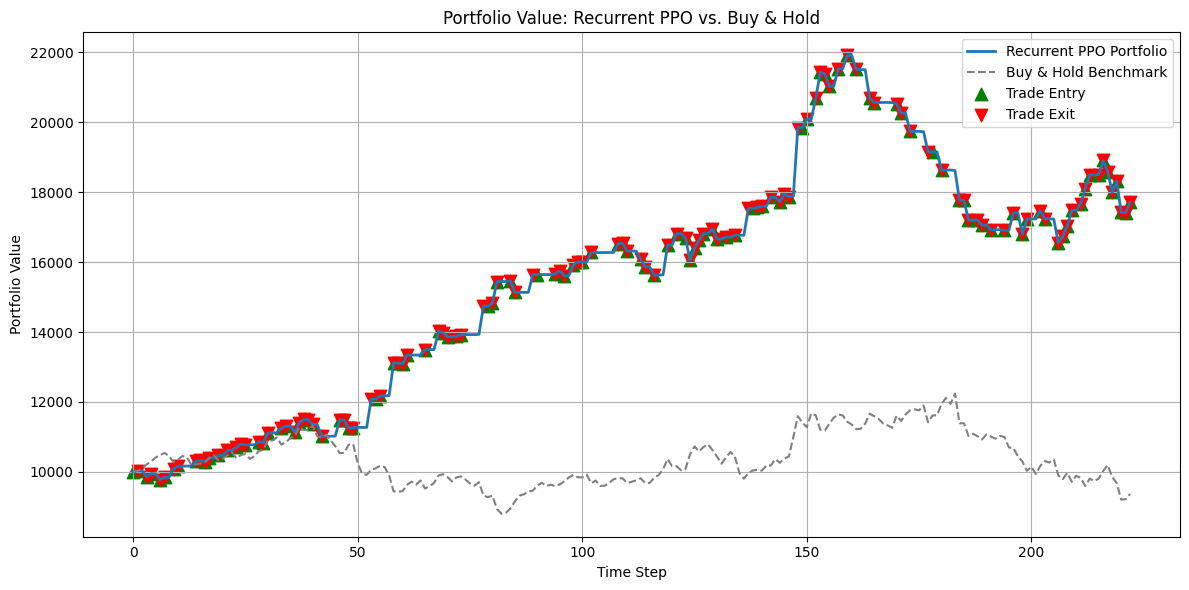

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

## AMZN

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 75644
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02, volatility_window=14, exploration_steps=1000, switch_cost=1.0):
        super().__init__()
        self.switch_cost = switch_cost
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # Calculate trade return
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'

        # Reward shaping
        reward = np.sign(trade_pct) * np.sqrt(abs(trade_pct)) * 10
        reward = np.clip(reward, -50, 50)

        # Apply transaction cost (after reward calculated)
        transaction_cost = TRANSACTION_COST * current_price
        reward -= transaction_cost
        self.balance -= transaction_cost

        # Penalize low-value trades
        if abs(trade_pct) < 0.5:
            reward -= 1.0

        # Update portfolio
        self.balance *= (1 + trade_pct / 100)
        self.cumulative_pnl += trade_pct
        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2)
        })

        # Reset position state
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # --- Position change logic with switching cost ---
        if self.position != 0 and self.position != target_position:
            reward += self._force_close()
            reward -= SWITCH_COST  # Apply switching cost

        # --- Entry logic ---
        if self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 0

        # --- Daily reward ---
        self.hold_counter += 1
        hold_limit = self.data.iloc[self.current_step]['adaptive_hold']
        price_change = (current_price - self.entry_price) / self.entry_price
        step_return = price_change if self.position == 1 else -price_change
        step_reward = 100 * step_return - self.hold_cost
        reward += step_reward
        self.reward_tracker[action].append(step_reward)

        if self.hold_counter >= hold_limit:
            reward += self._force_close()

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1
        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        pd.DataFrame(self.trade_log).to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=3e-4,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

# --- Evaluation with Accurate MTM Portfolio Tracking ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (current_price - env.entry_price) if env.position == 1 else (env.entry_price - current_price) if env.position == -1 else 0.0
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

env.save_trade_log("trade_log_recurrent.csv")
print(f"\nTotal Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")

Using cuda device
----------------------------
| time/              |     |
|    fps             | 334 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 123          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 0.0014650561 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.693       |
|    explained_variance   | -0.00522     |
|    learning_rate        | 0.0003       |
|    loss                 | 201          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00133     |
|    value_loss           | 804          |
------------------------------------------
-----

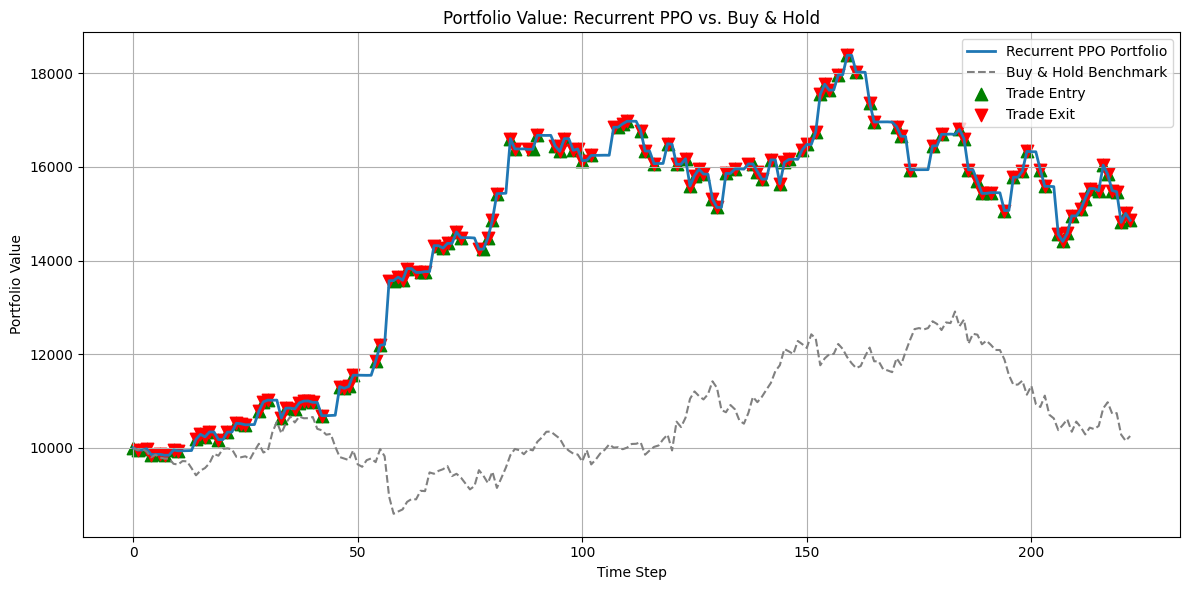

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

## AAPL

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 75699
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02, volatility_window=14, exploration_steps=1000, switch_cost=1.0):
        super().__init__()
        self.switch_cost = switch_cost
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # Calculate trade return
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'

        # Reward shaping
        reward = np.sign(trade_pct) * np.sqrt(abs(trade_pct)) * 10
        reward = np.clip(reward, -50, 50)

        # Apply transaction cost (after reward calculated)
        transaction_cost = TRANSACTION_COST * current_price
        reward -= transaction_cost
        self.balance -= transaction_cost

        # Penalize low-value trades
        if abs(trade_pct) < 0.5:
            reward -= 1.0

        # Update portfolio
        self.balance *= (1 + trade_pct / 100)
        self.cumulative_pnl += trade_pct
        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2)
        })

        # Reset position state
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # --- Position change logic with switching cost ---
        if self.position != 0 and self.position != target_position:
            reward += self._force_close()
            reward -= SWITCH_COST  # Apply switching cost

        # --- Entry logic ---
        if self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 0

        # --- Daily reward ---
        self.hold_counter += 1
        hold_limit = self.data.iloc[self.current_step]['adaptive_hold']
        price_change = (current_price - self.entry_price) / self.entry_price
        step_return = price_change if self.position == 1 else -price_change
        step_reward = 100 * step_return - self.hold_cost
        reward += step_reward
        self.reward_tracker[action].append(step_reward)

        if self.hold_counter >= hold_limit:
            reward += self._force_close()

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1
        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        pd.DataFrame(self.trade_log).to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=3e-4,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

# --- Evaluation with Accurate MTM Portfolio Tracking ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (current_price - env.entry_price) if env.position == 1 else (env.entry_price - current_price) if env.position == -1 else 0.0
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

env.save_trade_log("trade_log_recurrent.csv")
print(f"\nTotal Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")

Using cuda device
----------------------------
| time/              |     |
|    fps             | 294 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 0.0022987463 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.692       |
|    explained_variance   | -0.00331     |
|    learning_rate        | 0.0003       |
|    loss                 | 916          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00314     |
|    value_loss           | 4.23e+03     |
------------------------------------------
-----

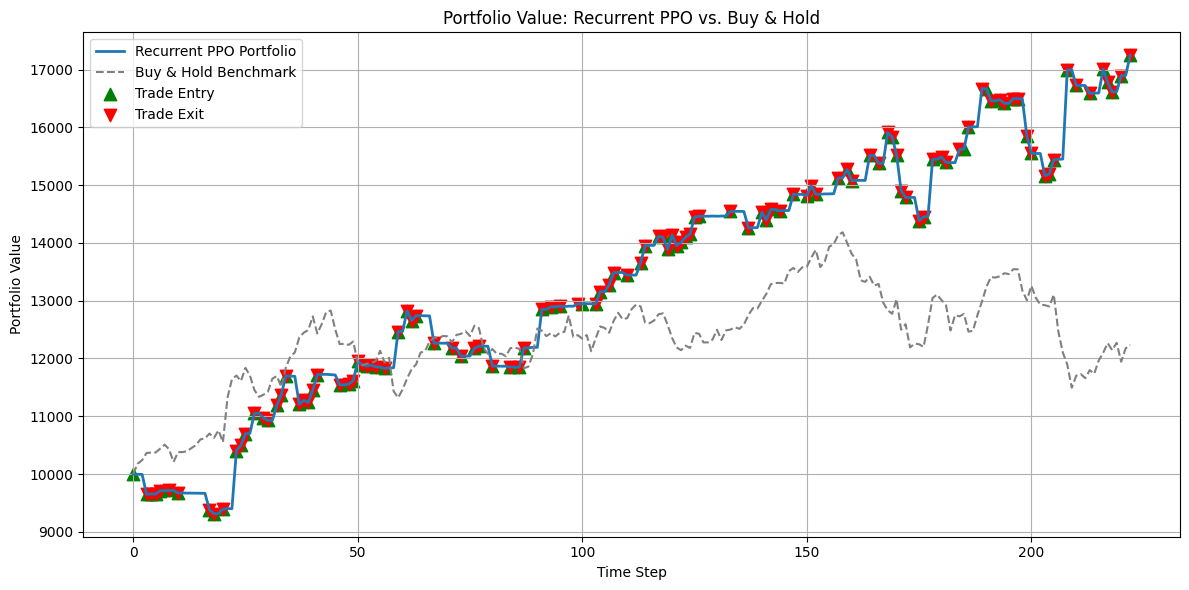

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

In [ ]:
# Original Seed Sweep

import numpy as np
import pandas as pd
import torch
import random
from stable_baselines3.common.utils import set_random_seed
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Sweep Parameters ---
CENTER_SEED = 83819
N_TRIALS = 11  # Total number of seeds to evaluate
TOTAL_TIMESTEPS = 3000

# --- Prepare Seed List ---
np.random.seed(CENTER_SEED)  # For reproducibility
random_below_seeds = np.random.choice(
    np.arange(0, CENTER_SEED),  # only below the center
    size=N_TRIALS - 1,
    replace=False
)
all_seeds = [CENTER_SEED] + list(random_below_seeds)

# --- Result Tracking ---
results = []
best_model = None
best_score = -np.inf
best_seed = None

# --- Sweep Loop ---
for seed in all_seeds:
    print(f"\n--- Training with seed {seed} ---")

    seed = int(seed)
    set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # Re-init environment and model
    env = TradingEnvRL(data.copy(), initial_balance=10000)
    vec_env = DummyVecEnv([lambda: env])
    vec_env.seed(seed)

    model = RecurrentPPO(
        policy=MlpLstmPolicy,
        env=vec_env,
        seed=seed,
        verbose=1,
        n_steps=64,
        batch_size=32,
        learning_rate=3e-4,
        gamma=0.99,
        ent_coef=0.01
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS)

    # Evaluation
    obs, _ = env.reset()
    state = None
    done = False
    total_reward = 0

    while not done:
        action, state = model.predict(obs, state=state, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    final_balance = env.balance
    print(f"Seed {seed}: Reward = {total_reward:.2f}, Final Balance = {final_balance:.2f}")

    results.append((seed, total_reward, final_balance))

    if total_reward > best_score:
        best_score = total_reward
        best_model = model
        best_seed = seed
        model.save("best_recurrent_model.zip")
        print("Best model updated and saved.")

# --- Save Results ---
results_df = pd.DataFrame(results, columns=["Seed", "Reward", "Final Balance"])
results_df.to_csv("seed_sweep_results.csv", index=False)

print("\n--- Seed Sweep Complete ---")
print(f"Best Seed: {best_seed}")
print(f"Best Total Reward: {best_score:.2f}")
print("Results saved to 'seed_sweep_results.csv'")

## META

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 49274
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02, volatility_window=14, exploration_steps=1000, switch_cost=1.0):
        super().__init__()
        self.switch_cost = switch_cost
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # Calculate trade return
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'

        # Reward shaping
        reward = np.sign(trade_pct) * np.sqrt(abs(trade_pct)) * 10
        reward = np.clip(reward, -50, 50)

        # Apply transaction cost (after reward calculated)
        transaction_cost = TRANSACTION_COST * current_price
        reward -= transaction_cost
        self.balance -= transaction_cost

        # Penalize low-value trades
        if abs(trade_pct) < 0.5:
            reward -= 1.0

        # Update portfolio
        self.balance *= (1 + trade_pct / 100)
        self.cumulative_pnl += trade_pct
        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2)
        })

        # Reset position state
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # --- Position change logic with switching cost ---
        if self.position != 0 and self.position != target_position:
            reward += self._force_close()
            reward -= SWITCH_COST  # Apply switching cost

        # --- Entry logic ---
        if self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 0

        # --- Daily reward ---
        self.hold_counter += 1
        hold_limit = self.data.iloc[self.current_step]['adaptive_hold']
        price_change = (current_price - self.entry_price) / self.entry_price
        step_return = price_change if self.position == 1 else -price_change
        step_reward = 100 * step_return - self.hold_cost
        reward += step_reward
        self.reward_tracker[action].append(step_reward)

        if self.hold_counter >= hold_limit:
            reward += self._force_close()

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1
        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        pd.DataFrame(self.trade_log).to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=3e-4,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

# --- Evaluation with Accurate MTM Portfolio Tracking ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (current_price - env.entry_price) if env.position == 1 else (env.entry_price - current_price) if env.position == -1 else 0.0
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

env.save_trade_log("trade_log_recurrent.csv")
print(f"\nTotal Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")

Using cuda device
----------------------------
| time/              |     |
|    fps             | 309 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 116          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 0.0044350056 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.691       |
|    explained_variance   | -0.00223     |
|    learning_rate        | 0.0003       |
|    loss                 | 670          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00438     |
|    value_loss           | 1e+03        |
------------------------------------------
-----

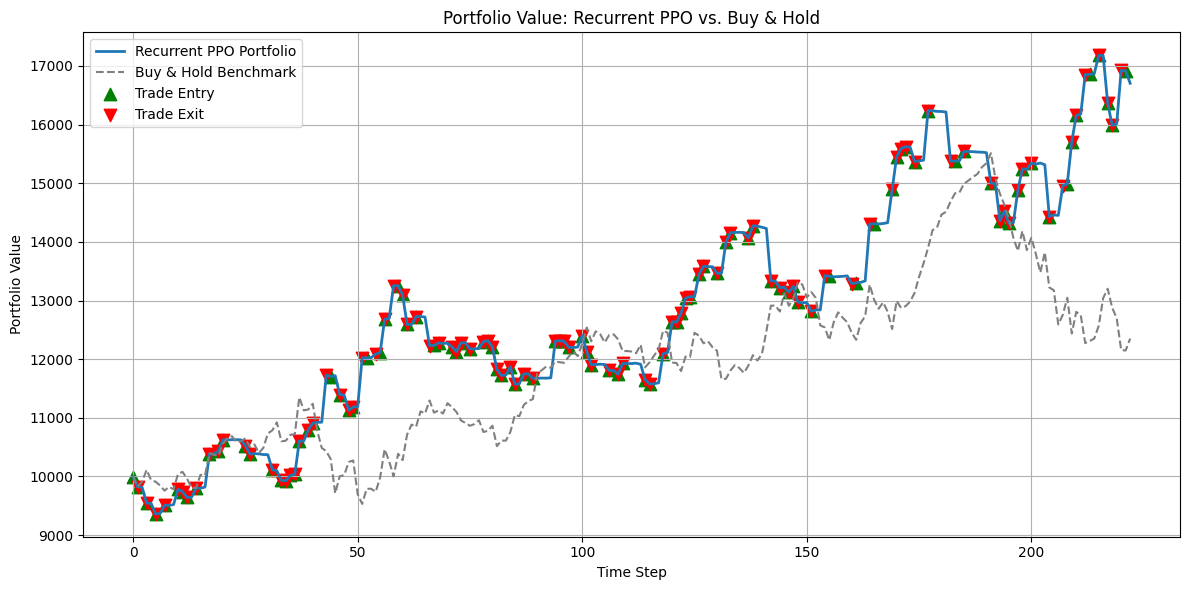

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

## MSFT

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 83828
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02, volatility_window=14, exploration_steps=1000, switch_cost=1.0):
        super().__init__()
        self.switch_cost = switch_cost
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # Calculate trade return
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'

        # Reward shaping
        reward = np.sign(trade_pct) * np.sqrt(abs(trade_pct)) * 10
        reward = np.clip(reward, -50, 50)

        # Apply transaction cost (after reward calculated)
        transaction_cost = TRANSACTION_COST * current_price
        reward -= transaction_cost
        self.balance -= transaction_cost

        # Penalize low-value trades
        if abs(trade_pct) < 0.5:
            reward -= 1.0

        # Update portfolio
        self.balance *= (1 + trade_pct / 100)
        self.cumulative_pnl += trade_pct
        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2)
        })

        # Reset position state
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # --- Position change logic with switching cost ---
        if self.position != 0 and self.position != target_position:
            reward += self._force_close()
            reward -= SWITCH_COST  # Apply switching cost

        # --- Entry logic ---
        if self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 0

        # --- Daily reward ---
        self.hold_counter += 1
        hold_limit = self.data.iloc[self.current_step]['adaptive_hold']
        price_change = (current_price - self.entry_price) / self.entry_price
        step_return = price_change if self.position == 1 else -price_change
        step_reward = 100 * step_return - self.hold_cost
        reward += step_reward
        self.reward_tracker[action].append(step_reward)

        if self.hold_counter >= hold_limit:
            reward += self._force_close()

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1
        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        pd.DataFrame(self.trade_log).to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=128,
    batch_size=64,
    learning_rate=3e-4,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=10000)

# --- Evaluation with Accurate MTM Portfolio Tracking ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (current_price - env.entry_price) if env.position == 1 else (env.entry_price - current_price) if env.position == -1 else 0.0
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

env.save_trade_log("trade_log_recurrent.csv")
print(f"\nTotal Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")

Using cuda device
----------------------------
| time/              |     |
|    fps             | 332 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 128 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 130           |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 256           |
| train/                  |               |
|    approx_kl            | 0.00015117228 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.693        |
|    explained_variance   | 0.00225       |
|    learning_rate        | 0.0003        |
|    loss                 | 151           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00022      |
|    value_loss           | 529           |
-------------------------------

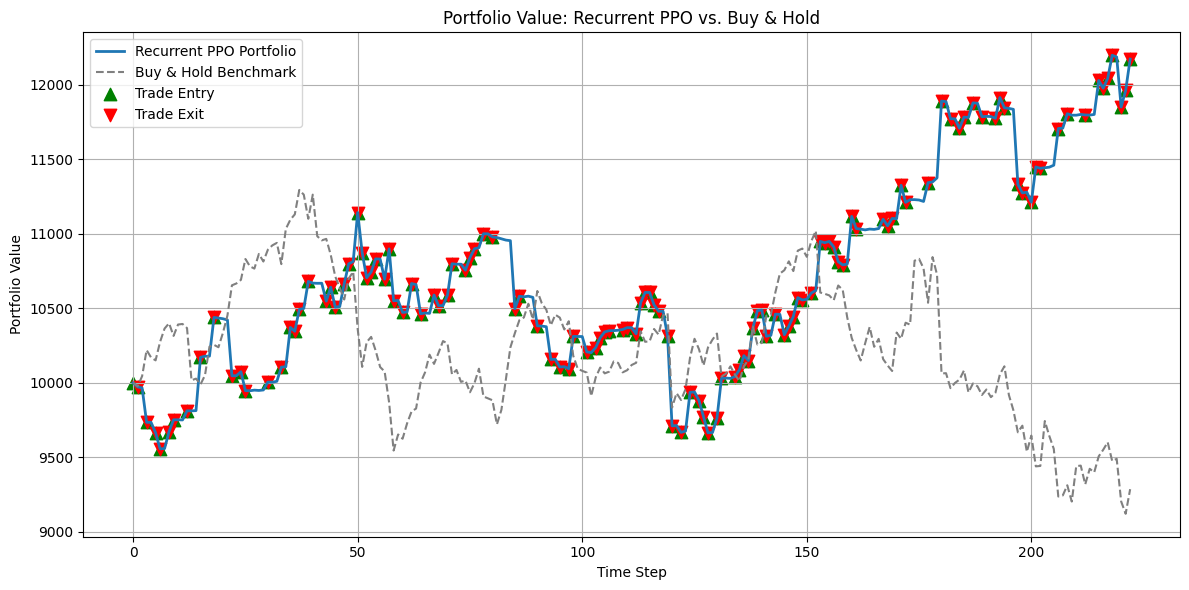

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

In [ ]:
# Original Seed Sweep

import numpy as np
import pandas as pd
from stable_baselines3.common.utils import set_random_seed
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

# Function with verbose training
def train_with_seed(seed, data, total_timesteps=10000):
    print(f"\n--- Training with seed {seed} ---")
    set_random_seed(seed)
    np.random.seed(seed)

    env = TradingEnvRL(data, initial_balance=10000)
    vec_env = DummyVecEnv([lambda: env])

    model = RecurrentPPO(
        policy=MlpLstmPolicy,
        env=vec_env,
        seed=seed,
        verbose=1,  # Enable live training output
        n_steps=128,
        batch_size=64,
        learning_rate=3e-4,
        gamma=0.99,
        ent_coef=0.01
    )

    model.learn(total_timesteps=total_timesteps)

    # Evaluate final performance
    obs, _ = env.reset()
    state = None
    done = False
    total_reward = 0

    while not done:
        action, state = model.predict(obs, state=state, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    final_balance = env.balance
    env.save_trade_log(f"trade_log_seed_{seed}.csv")

    print(f"Finished seed {seed}: Reward = {total_reward:.2f}, Final Balance = {final_balance:.2f}")
    return model, total_reward, final_balance, seed

# Sweep setup
num_trials = 5
results = []
best_model = None
best_score = -np.inf
best_seed = None

for trial_seed in range(83819, 83819 + num_trials):
    model, reward, balance, seed = train_with_seed(trial_seed, data)
    results.append((seed, reward, balance))

    if reward > best_score:
        best_score = reward
        best_model = model
        best_seed = seed
        model.save("best_recurrent_model.zip")

# Save results
results_df = pd.DataFrame(results, columns=["Seed", "Reward", "Final Balance"])
results_df.to_csv("seed_sweep_results.csv", index=False)

print("\n--- Best Run Summary ---")
print(f"Seed: {best_seed}")
print(f"Total Reward: {best_score:.2f}")
print("Model saved as 'best_recurrent_model.zip'")

## NVDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 115661
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02, volatility_window=14, exploration_steps=1000, switch_cost=1.0):
        super().__init__()
        self.switch_cost = switch_cost
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # Calculate trade return
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'

        # Reward shaping
        reward = np.sign(trade_pct) * np.sqrt(abs(trade_pct)) * 10
        reward = np.clip(reward, -50, 50)

        # Apply transaction cost (after reward calculated)
        transaction_cost = TRANSACTION_COST * current_price
        reward -= transaction_cost
        self.balance -= transaction_cost

        # Penalize low-value trades
        if abs(trade_pct) < 0.5:
            reward -= 1.0

        # Update portfolio
        self.balance *= (1 + trade_pct / 100)
        self.cumulative_pnl += trade_pct
        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2)
        })

        # Reset position state
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # --- Position change logic with switching cost ---
        if self.position != 0 and self.position != target_position:
            reward += self._force_close()
            reward -= SWITCH_COST  # Apply switching cost

        # --- Entry logic ---
        if self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 0

        # --- Daily reward ---
        self.hold_counter += 1
        hold_limit = self.data.iloc[self.current_step]['adaptive_hold']
        price_change = (current_price - self.entry_price) / self.entry_price
        step_return = price_change if self.position == 1 else -price_change
        step_reward = 100 * step_return - self.hold_cost
        reward += step_reward
        self.reward_tracker[action].append(step_reward)

        if self.hold_counter >= hold_limit:
            reward += self._force_close()

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1
        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        pd.DataFrame(self.trade_log).to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=3e-4,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

# --- Evaluation with Accurate MTM Portfolio Tracking ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (current_price - env.entry_price) if env.position == 1 else (env.entry_price - current_price) if env.position == -1 else 0.0
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

env.save_trade_log("trade_log_recurrent.csv")
print(f"\nTotal Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")

Using cuda device
----------------------------
| time/              |     |
|    fps             | 335 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 126           |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 128           |
| train/                  |               |
|    approx_kl            | 0.00085067004 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.693        |
|    explained_variance   | 0.00634       |
|    learning_rate        | 0.0003        |
|    loss                 | 241           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00111      |
|    value_loss           | 961           |
-------------------------------

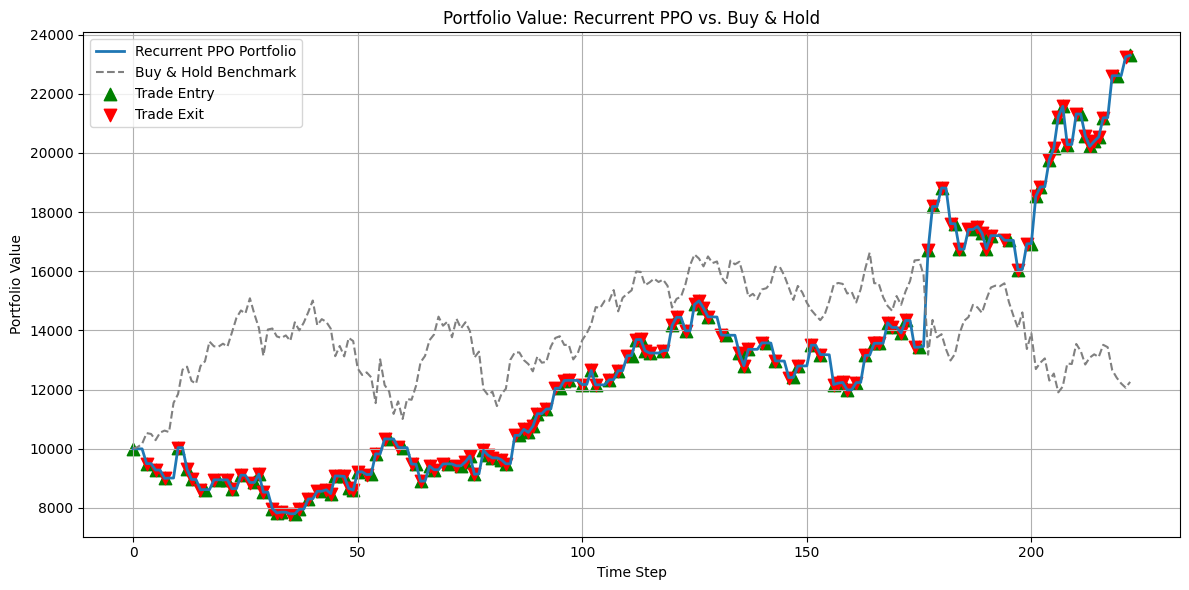

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

## TSLA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 133516
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0  # or higher if switching is too frequent
TRANSACTION_COST = 0.001  # 0.1%

# --- Custom Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02, volatility_window=14, exploration_steps=1000, switch_cost=1.0):
        super().__init__()
        self.switch_cost = switch_cost
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'zlma', 'ema_value',
            'DSSb', 'DSSsignal',
            'rsi_ma_base',
            'ZeroLagMACD', 'ZeroLagMACD_signal',
            'basicMACD', 'basicMACD_signal',
            'ZScore',
            'ZLMA_Buy', 'ZLMA_Sell',
            'RSI_Buy', 'RSI_Sell',
            'MCDX_Buy', 'MCDX_Sell',
            'DSS_Buy', 'DSS_Sell',
            'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # Calculate trade return
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'

        # Reward shaping
        reward = np.sign(trade_pct) * np.sqrt(abs(trade_pct)) * 10
        reward = np.clip(reward, -50, 50)

        # Apply transaction cost (after reward calculated)
        transaction_cost = TRANSACTION_COST * current_price
        reward -= transaction_cost
        self.balance -= transaction_cost

        # Penalize low-value trades
        if abs(trade_pct) < 0.5:
            reward -= 1.0

        # Update portfolio
        self.balance *= (1 + trade_pct / 100)
        self.cumulative_pnl += trade_pct
        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2)
        })

        # Reset position state
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # --- Position change logic with switching cost ---
        if self.position != 0 and self.position != target_position:
            reward += self._force_close()
            reward -= SWITCH_COST  # Apply switching cost

        # --- Entry logic ---
        if self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 0

        # --- Daily reward ---
        self.hold_counter += 1
        hold_limit = self.data.iloc[self.current_step]['adaptive_hold']
        price_change = (current_price - self.entry_price) / self.entry_price
        step_return = price_change if self.position == 1 else -price_change
        step_reward = 100 * step_return - self.hold_cost
        reward += step_reward
        self.reward_tracker[action].append(step_reward)

        if self.hold_counter >= hold_limit:
            reward += self._force_close()

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1
        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        pd.DataFrame(self.trade_log).to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=3e-4,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED
)

model.learn(total_timesteps=3000)

# --- Evaluation with Accurate MTM Portfolio Tracking ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (current_price - env.entry_price) if env.position == 1 else (env.entry_price - current_price) if env.position == -1 else 0.0
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

env.save_trade_log("trade_log_recurrent.csv")
print(f"\nTotal Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")

Using cuda device
----------------------------
| time/              |     |
|    fps             | 302 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 0.0003483966 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.693       |
|    explained_variance   | 0.00236      |
|    learning_rate        | 0.0003       |
|    loss                 | 487          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000727    |
|    value_loss           | 1.08e+03     |
------------------------------------------
-----

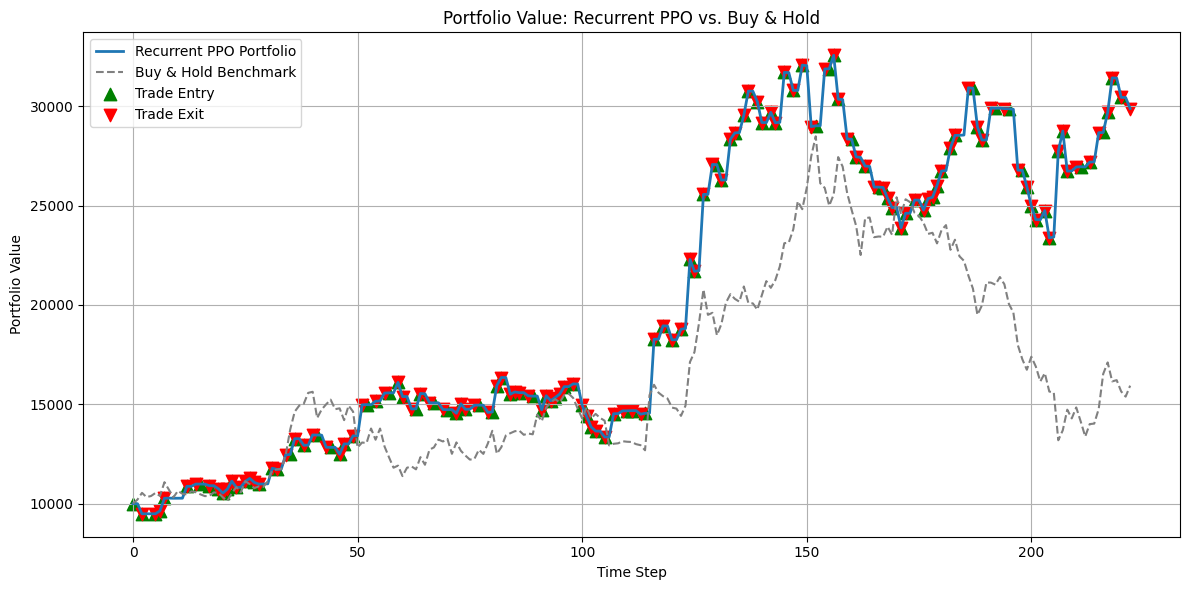

In [ ]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

## Changelog

### Version: 2.1.0
- New major features: Recurrent PPO module training, seed search, and portfolio performance testing
- Removed DQN module
- Improved CSV saving function

1.2.3
- Adjusted default weights

### 1.2.2
- Fixed trade table
- Minor formatting

### 1.2.1
- Added trade table
- Added user adjustable weights
- Added basic MACD
- Added trade signals